In [117]:
import re

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import xgboost as xgb
# from itertools import pairwise

In [2]:
import matplotlib.pyplot as plt

In [3]:
class Config:
    base_dir_path = f"data/"

    train_logs = f"{base_dir_path}train_logs.csv"
    train_scores = f"{base_dir_path}train_scores.csv"
    test_logs = f"{base_dir_path}test_logs.csv"

In [4]:
cnfg = Config()

In [5]:
train_logs_df = pd.read_csv(cnfg.train_logs)

In [6]:
train_logs_df.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [7]:
train_logs_df.id.nunique()

2471

In [8]:
train_logs_df = train_logs_df.sort_values(["id", "event_id"]).reset_index(drop=True)

In [97]:
train_scores = pd.read_csv(cnfg.train_scores)

In [99]:
# train_scores

In [9]:
# train_logs_df.groupby(['id'],as_index=False).agg(event_ids = ('event_id', list),

#                                                 )

In [10]:
grpd_df = train_logs_df.groupby(["id"], as_index=False).agg(
    lambda x: list(x),
)

In [11]:
grpd_df.head()

id                                           event_id  \
0  001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           down_time  \
0  [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1  [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2  [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3  [41395, 143203, 147422, 147627, 147655, 147687...   
4  [78470, 94232, 94454, 94795, 94963, 95232, 954...   

                                             up_time  \
0  [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1  [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2  [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3  [41513, 143261, 147422, 147627, 147655, 147687...   
4  [78693, 94232, 94617, 95006, 95149, 95359, 956...   

                                         action_time  \
0  [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1  [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2  [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3  [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   

                                            activity  \
0  [Nonproduction, Nonproduction, Nonproduction, ...   
1  [Nonproduction, Nonproduction, Input, Input, I...   
2  [Nonproduction, Nonproduction, Input, Input, I...   
3  [Nonproduction, Nonproduction, Nonproduction, ...   
4  [Nonproduction, Nonproduction, Input, Input, I...   

                                          down_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                            up_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                         text_change  \
0  [NoChange, NoChange, NoChange, q, q, q, q, q, ...   
1  [NoChange, NoChange, q, q, q, q,  , q, q,  , N...   
2  [NoChange, NoChange, q, q, q, q, q, q, q,  , q...   
3  [NoChange, NoChange, NoChange, NoChange, NoCha...   
4  [NoChange, NoChange, q, q, q, q, q, q, q, q, q...   

                                     cursor_position  \
0  [0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...   
1  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 1...   
2  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   

                                          word_count  
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...  
1  [0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, ...  
2  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...

In [12]:
grpd_df["num_events"] = grpd_df.apply(lambda x: len(x.event_id), axis=1)

In [13]:
grpd_df.head()

id                                           event_id  \
0  001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           down_time  \
0  [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1  [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2  [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3  [41395, 143203, 147422, 147627, 147655, 147687...   
4  [78470, 94232, 94454, 94795, 94963, 95232, 954...   

                                             up_time  \
0  [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1  [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2  [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3  [41513, 143261, 147422, 147627, 147655, 147687...   
4  [78693, 94232, 94617, 95006, 95149, 95359, 956...   

                                         action_time  \
0  [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1  [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2  [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3  [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   

                                            activity  \
0  [Nonproduction, Nonproduction, Nonproduction, ...   
1  [Nonproduction, Nonproduction, Input, Input, I...   
2  [Nonproduction, Nonproduction, Input, Input, I...   
3  [Nonproduction, Nonproduction, Nonproduction, ...   
4  [Nonproduction, Nonproduction, Input, Input, I...   

                                          down_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                            up_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                         text_change  \
0  [NoChange, NoChange, NoChange, q, q, q, q, q, ...   
1  [NoChange, NoChange, q, q, q, q,  , q, q,  , N...   
2  [NoChange, NoChange, q, q, q, q, q, q, q,  , q...   
3  [NoChange, NoChange, NoChange, NoChange, NoCha...   
4  [NoChange, NoChange, q, q, q, q, q, q, q, q, q...   

                                     cursor_position  \
0  [0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...   
1  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 1...   
2  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   

                                          word_count  num_events  
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        2557  
1  [0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, ...        2454  
2  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        4136  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        1556  
4  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...        2531

In [16]:
grpd_df["total_time_taken"] = grpd_df.down_time.apply(lambda x: (x[-1] - x[0]) / 1000)

<Axes: >

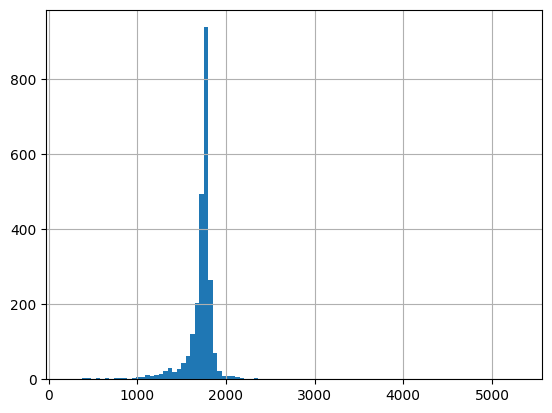

In [19]:
grpd_df.total_time_taken.hist(bins=100)

<Axes: >

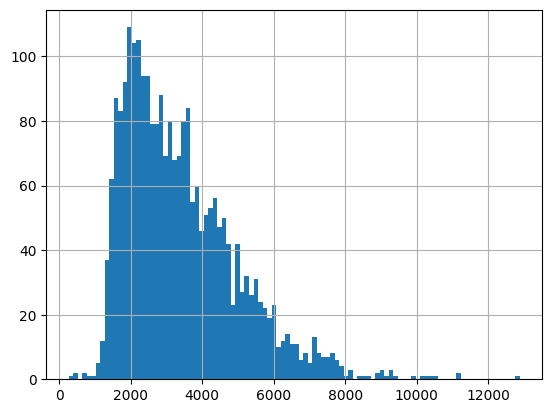

In [30]:
grpd_df.num_events.hist(bins=100)

In [37]:
cuts = [i for i in range(0, 5500, 500)] + [float("inf")]

In [38]:
cuts

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, inf]

In [39]:
grpd_df["time_taken_group"] = pd.cut(
    grpd_df["total_time_taken"], cuts, labels=[f"grp_{k}" for k in cuts[1:]]
)

In [40]:
grpd_df.time_taken_group.value_counts()

time_taken_group
grp_2000    2227
grp_1500     154
grp_2500      36
grp_1000      28
grp_3000       9
grp_500        8
grp_4000       4
grp_3500       2
grp_4500       1
grp_5000       1
grp_inf        1
Name: count, dtype: int64

In [41]:
grpd_df.head()

id                                           event_id  \
0  001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           down_time  \
0  [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1  [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2  [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3  [41395, 143203, 147422, 147627, 147655, 147687...   
4  [78470, 94232, 94454, 94795, 94963, 95232, 954...   

                                             up_time  \
0  [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1  [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2  [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3  [41513, 143261, 147422, 147627, 147655, 147687...   
4  [78693, 94232, 94617, 95006, 95149, 95359, 956...   

                                         action_time  \
0  [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1  [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2  [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3  [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   

                                            activity  \
0  [Nonproduction, Nonproduction, Nonproduction, ...   
1  [Nonproduction, Nonproduction, Input, Input, I...   
2  [Nonproduction, Nonproduction, Input, Input, I...   
3  [Nonproduction, Nonproduction, Nonproduction, ...   
4  [Nonproduction, Nonproduction, Input, Input, I...   

                                          down_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                            up_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                         text_change  \
0  [NoChange, NoChange, NoChange, q, q, q, q, q, ...   
1  [NoChange, NoChange, q, q, q, q,  , q, q,  , N...   
2  [NoChange, NoChange, q, q, q, q, q, q, q,  , q...   
3  [NoChange, NoChange, NoChange, NoChange, NoCha...   
4  [NoChange, NoChange, q, q, q, q, q, q, q, q, q...   

                                     cursor_position  \
0  [0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...   
1  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 1...   
2  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   

                                          word_count  num_events  \
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        2557   
1  [0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, ...        2454   
2  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        4136   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        1556   
4  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...        2531   

   total_time_taken time_taken_group  ne_group  
0          1797.351         grp_2000  grp_3000  
1          1758.219         grp_2000  grp_2500  
2          1766.778         grp_2000  grp_4500  
3          1362.999         grp_1500  grp_2000  
4          1583.920         grp_2000  grp_3000

In [42]:
cuts_ne = [i for i in range(0, 12500, 500)] + [float("inf")]

In [118]:
cuts_ne = (
    [0]
    + [i for i in range(1500, 6000, 250)]
    + [i for i in range(6000, 8500, 500)]
    + [float("inf")]
)

In [119]:
cuts_ne

[0,
 1500,
 1750,
 2000,
 2250,
 2500,
 2750,
 3000,
 3250,
 3500,
 3750,
 4000,
 4250,
 4500,
 4750,
 5000,
 5250,
 5500,
 5750,
 6000,
 6500,
 7000,
 7500,
 8000,
 inf]

In [123]:
# pd.cut(
#     grpd_df["num_events"], cuts_ne, labels=[f"grp_{k}" for k in cuts_ne[1:]]
# ).values.tolist()

In [92]:
grpd_df["ne_group"] = pd.cut(
    grpd_df["num_events"], cuts_ne, labels=[f"grp_{k}" for k in cuts_ne[1:]]
)

In [93]:
grpd_df.head()

id                                           event_id  \
0  001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           down_time  \
0  [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1  [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2  [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3  [41395, 143203, 147422, 147627, 147655, 147687...   
4  [78470, 94232, 94454, 94795, 94963, 95232, 954...   

                                             up_time  \
0  [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1  [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2  [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3  [41513, 143261, 147422, 147627, 147655, 147687...   
4  [78693, 94232, 94617, 95006, 95149, 95359, 956...   

                                         action_time  \
0  [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1  [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2  [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3  [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   

                                            activity  \
0  [Nonproduction, Nonproduction, Nonproduction, ...   
1  [Nonproduction, Nonproduction, Input, Input, I...   
2  [Nonproduction, Nonproduction, Input, Input, I...   
3  [Nonproduction, Nonproduction, Nonproduction, ...   
4  [Nonproduction, Nonproduction, Input, Input, I...   

                                          down_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                            up_event  \
0  [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1  [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2  [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3  [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4  [Leftclick, Shift, q, q, q, q, q, q, q, q, q, ...   

                                         text_change  \
0  [NoChange, NoChange, NoChange, q, q, q, q, q, ...   
1  [NoChange, NoChange, q, q, q, q,  , q, q,  , N...   
2  [NoChange, NoChange, q, q, q, q, q, q, q,  , q...   
3  [NoChange, NoChange, NoChange, NoChange, NoCha...   
4  [NoChange, NoChange, q, q, q, q, q, q, q, q, q...   

                                     cursor_position  \
0  [0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...   
1  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 1...   
2  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...   

                                          word_count  num_events  \
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        2557   
1  [0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, ...        2454   
2  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...        4136   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        1556   
4  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...        2531   

   total_time_taken time_taken_group  ne_group  
0          1797.351         grp_2000  grp_2750  
1          1758.219         grp_2000  grp_2500  
2          1766.778         grp_2000  grp_4250  
3          1362.999         grp_1500  grp_1750  
4          1583.920         grp_2000  grp_2750

In [94]:
grpd_df.ne_group.unique()

['grp_2750', 'grp_2500', 'grp_4250', 'grp_1750', 'grp_2250', ..., 'grp_1500', 'grp_5000', 'grp_6500', 'grp_inf', 'grp_7000']
Length: 24
Categories (24, object): ['grp_1500' < 'grp_1750' < 'grp_2000' < 'grp_2250' ... 'grp_7000' < 'grp_7500' < 'grp_8000' < 'grp_inf']

In [95]:
grpd_df.ne_group.value_counts()[[f"grp_{k}" for k in cuts_ne[1:]]]

ne_group
grp_1500    108
grp_1750    170
grp_2000    195
grp_2250    205
grp_2500    185
grp_2750    165
grp_3000    153
grp_3250    152
grp_3500    147
grp_3750    143
grp_4000    109
grp_4250     96
grp_4500    102
grp_4750     95
grp_5000     71
grp_5250     61
grp_5500     56
grp_5750     50
grp_6000     40
grp_6500     55
grp_7000     34
grp_7500     30
grp_8000     24
grp_inf      25
Name: count, dtype: int64

In [103]:
# grpd_df[grpd_df.ne_group == 'grp_1500']

In [101]:
grpd_df = grpd_df.merge(train_scores, on="id")

In [106]:
for grp_clm in [f"grp_{k}" for k in cuts_ne[1:]]:
    tmp_df = grpd_df[grpd_df.ne_group == grp_clm]
    print(f"************ {grp_clm} ***********")
    print(tmp_df.score.value_counts(normalize=True), "\n\n")

************ grp_1500 ***********
score
2.5    0.212963
2.0    0.212963
1.5    0.203704
3.0    0.194444
1.0    0.111111
3.5    0.027778
0.5    0.027778
4.0    0.009259
Name: proportion, dtype: float64 


************ grp_1750 ***********
score
3.0    0.276471
2.5    0.229412
3.5    0.152941
2.0    0.123529
1.5    0.082353
4.0    0.082353
1.0    0.047059
0.5    0.005882
Name: proportion, dtype: float64 


************ grp_2000 ***********
score
3.5    0.287179
3.0    0.256410
2.5    0.174359
4.0    0.087179
2.0    0.087179
1.5    0.041026
4.5    0.030769
1.0    0.030769
0.5    0.005128
Name: proportion, dtype: float64 


************ grp_2250 ***********
score
3.5    0.312195
3.0    0.282927
4.0    0.160976
2.5    0.141463
4.5    0.048780
2.0    0.029268
1.5    0.009756
1.0    0.009756
5.0    0.004878
Name: proportion, dtype: float64 


************ grp_2500 ***********
score
3.5    0.302703
4.0    0.200000
3.0    0.200000
2.5    0.135135
2.0    0.059459
4.5    0.059459
1.5    0.021622


In [110]:
grpd_df['score_grp_rank'] = grpd_df.groupby('ne_group')['score'].rank("dense",ascending=True)

/tmp/ipykernel_3872/1375804157.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grpd_df['score_grp_rank'] = grpd_df.groupby('ne_group')['score'].rank("dense",ascending=True)


In [115]:
grpd_df = grpd_df.sort_values('ne_group').reset_index(drop=True)

In [113]:
grpd_df[grpd_df.ne_group == 'grp_1500'].sort_values('score')

id                                           event_id  \
1848  c3663a2d  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
302   1ebb9b74  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
469   315bdafd  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
45    044c5c54  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2331  f26e1dd2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
...        ...                                                ...   
1212  80567e1e  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1811  be24dd5d  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
223   1677c88a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1262  846d9750  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1735  b61221f1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              down_time  \
1848  [1076, 14572, 14816, 15008, 15248, 15488, 1579...   
302   [1889, 7314, 7487, 7879, 9079, 9471, 9583, 975...   
469   [1078, 68362, 71155, 75243, 78091, 107978, 140...   
45    [2376, 16976, 17177, 17385, 18793, 18985, 1999...   
2331  [1786, 2128, 7968, 8494, 8567, 8663, 8814, 892...   
...                                                 ...   
1212  [22763, 22970, 23824, 23936, 24169, 24347, 245...   
1811  [123246, 126035, 126233, 126429, 126639, 12682...   
223   [25901, 42716, 43283, 43548, 357204, 457819, 4...   
1262  [31791, 44444, 44524, 44660, 44917, 44997, 451...   
1735  [701527, 720696, 721329, 721829, 721838, 72184...   

                                                up_time  \
1848  [1200, 14650, 14896, 15112, 15352, 15608, 1599...   
302   [2000, 7432, 7576, 7984, 9215, 9551, 9719, 984...   
469   [1115, 68458, 71362, 75426, 78298, 108066, 140...   
45    [2429, 17035, 17225, 17449, 18857, 19049, 2005...   
2331  [1896, 2216, 8462, 8550, 8646, 8710, 8886, 897...   
...                                                 ...   
1212  [22937, 23113, 23824, 24084, 24263, 24419, 246...   
1811  [123336, 126035, 126332, 126545, 126746, 12694...   
223   [25977, 42823, 43283, 43693, 357314, 457897, 4...   
1262  [31908, 44444, 44623, 44845, 45035, 45133, 453...   
1735  [701583, 720744, 721336, 721829, 721838, 72185...   

                                            action_time  \
1848  [124, 78, 80, 104, 104, 120, 200, 176, 144, 17...   
302   [111, 118, 89, 105, 136, 80, 136, 88, 95, 128,...   
469   [37, 96, 207, 183, 207, 88, 86, 57, 56, 492, 3...   
45    [53, 59, 48, 64, 64, 64, 63, 48, 48, 96, 48, 3...   
2331  [110, 88, 494, 56, 79, 47, 72, 48, 48, 64, 71,...   
...                                                 ...   
1212  [174, 143, 0, 148, 94, 72, 73, 134, 138, 129, ...   
1811  [90, 0, 99, 116, 107, 121, 133, 100, 149, 79, ...   
223   [76, 107, 0, 145, 110, 78, 73, 0, 0, 64, 91, 7...   
1262  [117, 0, 99, 185, 118, 136, 144, 104, 137, 95,...   
1735  [56, 48, 7, 0, 0, 9, 0, 0, 10, 10, 0, 0, 9, 64...   

                                               activity  \
1848  [Nonproduction, Input, Input, Input, Input, In...   
302   [Nonproduction, Input, Input, Input, Remove/Cu...   
469   [Nonproduction, Nonproduction, Nonproduction, ...   
45    [Nonproduction, Input, Input, Input, Input, In...   
2331  [Nonproduction, Input, Nonproduction, Input, N...   
...                                                 ...   
1212  [Nonproduction, Nonproduction, Nonproduction, ...   
1811  [Nonproduction, Nonproduction, Input, Input, I...   
223   [Nonproduction, Nonproduction, Nonproduction, ...   
1262  [Nonproduction, Nonproduction, Input, Input, I...   
1735  [Nonproduction, Nonproduction, Input, Nonprodu...   

                                             down_event  \
1848  [Leftclick, q, q, Space, q, q, q, q, Space, q,...   
302   [Leftclick, q, q, q, Backspace, q, q, Space, q...   
469   [Leftclick, Leftclick, Leftclick, Leftclick, L...   
45    [Leftclick, q, q, Space, q, q, Backspace, q, q...   
2331  [Leftclick, Enter, CapsLock, q, CapsLock, q, q

In [14]:
grpd_df.num_events.describe()

count     2471.000000
mean      3401.820316
std       1578.850387
min        262.000000
25%       2193.500000
50%       3082.000000
75%       4301.000000
max      12876.000000
Name: num_events, dtype: float64

<Axes: >

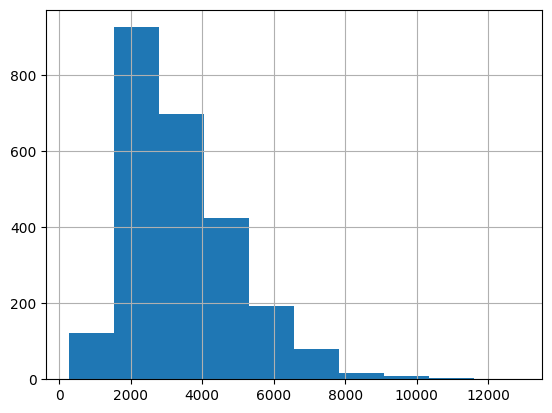

In [15]:
grpd_df.num_events.hist()

In [16]:
clms = [
    "down_time",
    "up_time",
    "action_time",
    "activity",
    "down_event",
    "up_event",
    "text_change",
    "cursor_position",
    "word_count",
]
num_clms = len(clms)

In [17]:
def plot_all_timeseries_events(sample):
    # define subplot grid
    fig, axs = plt.subplots(nrows=num_clms // 3, ncols=3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(f"{sample.id}", fontsize=18, y=0.95)

    # loop through tickers and axes
    for clm, ax in zip(clms, axs.ravel()):
        ax.plot(sample.event_id, sample[clm])
        # chart formatting
        ax.set_title(clm)
        #     ax.get_legend().remove()
        ax.set_xlabel("event_id")

    plt.show()

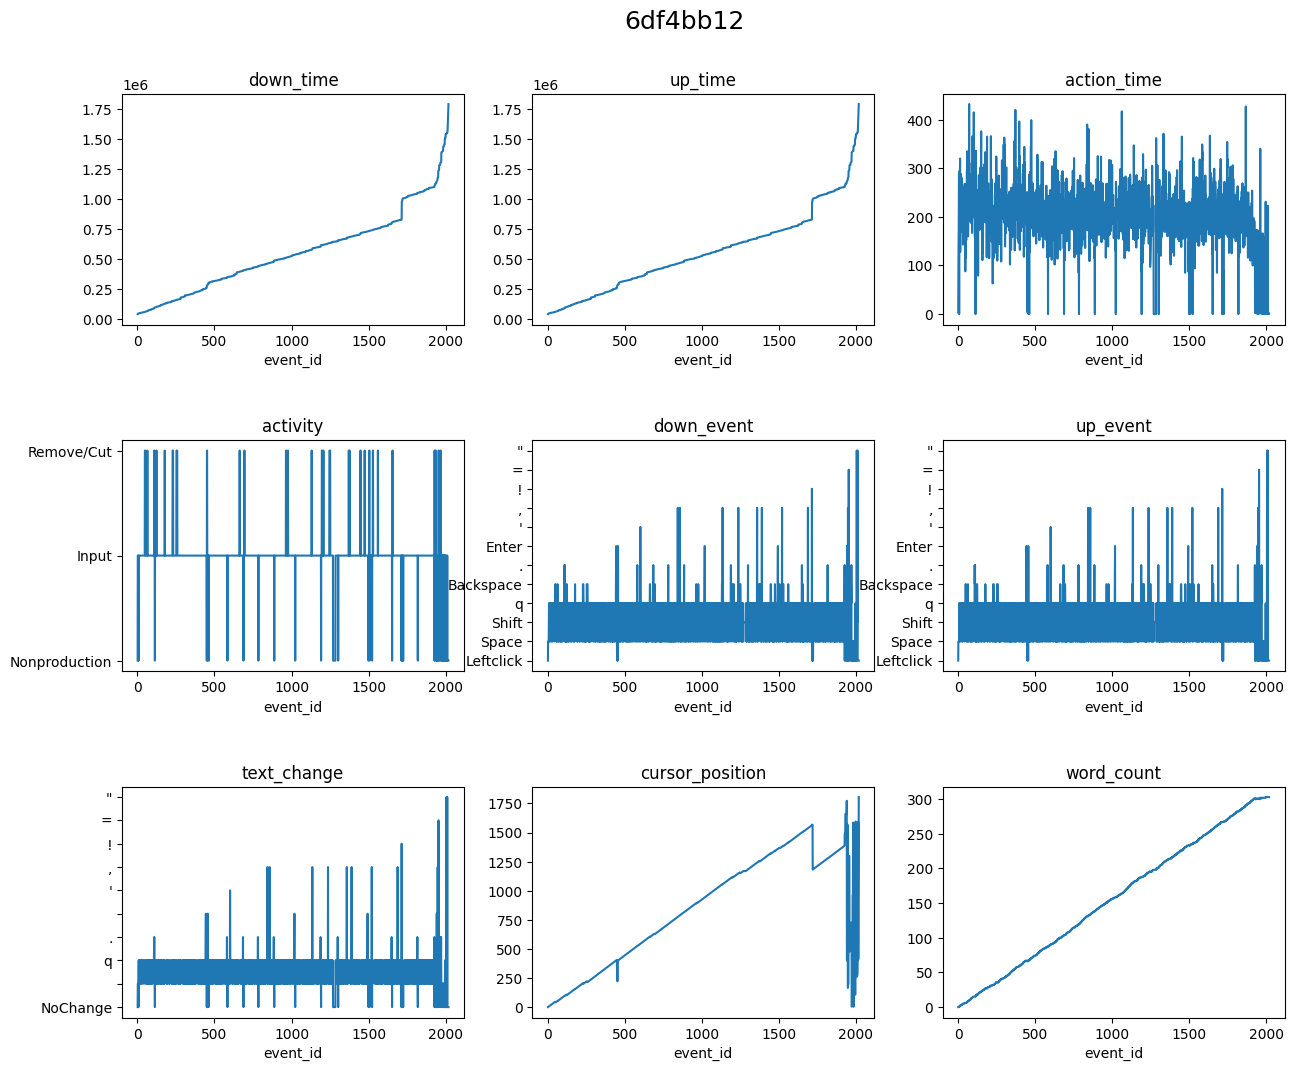

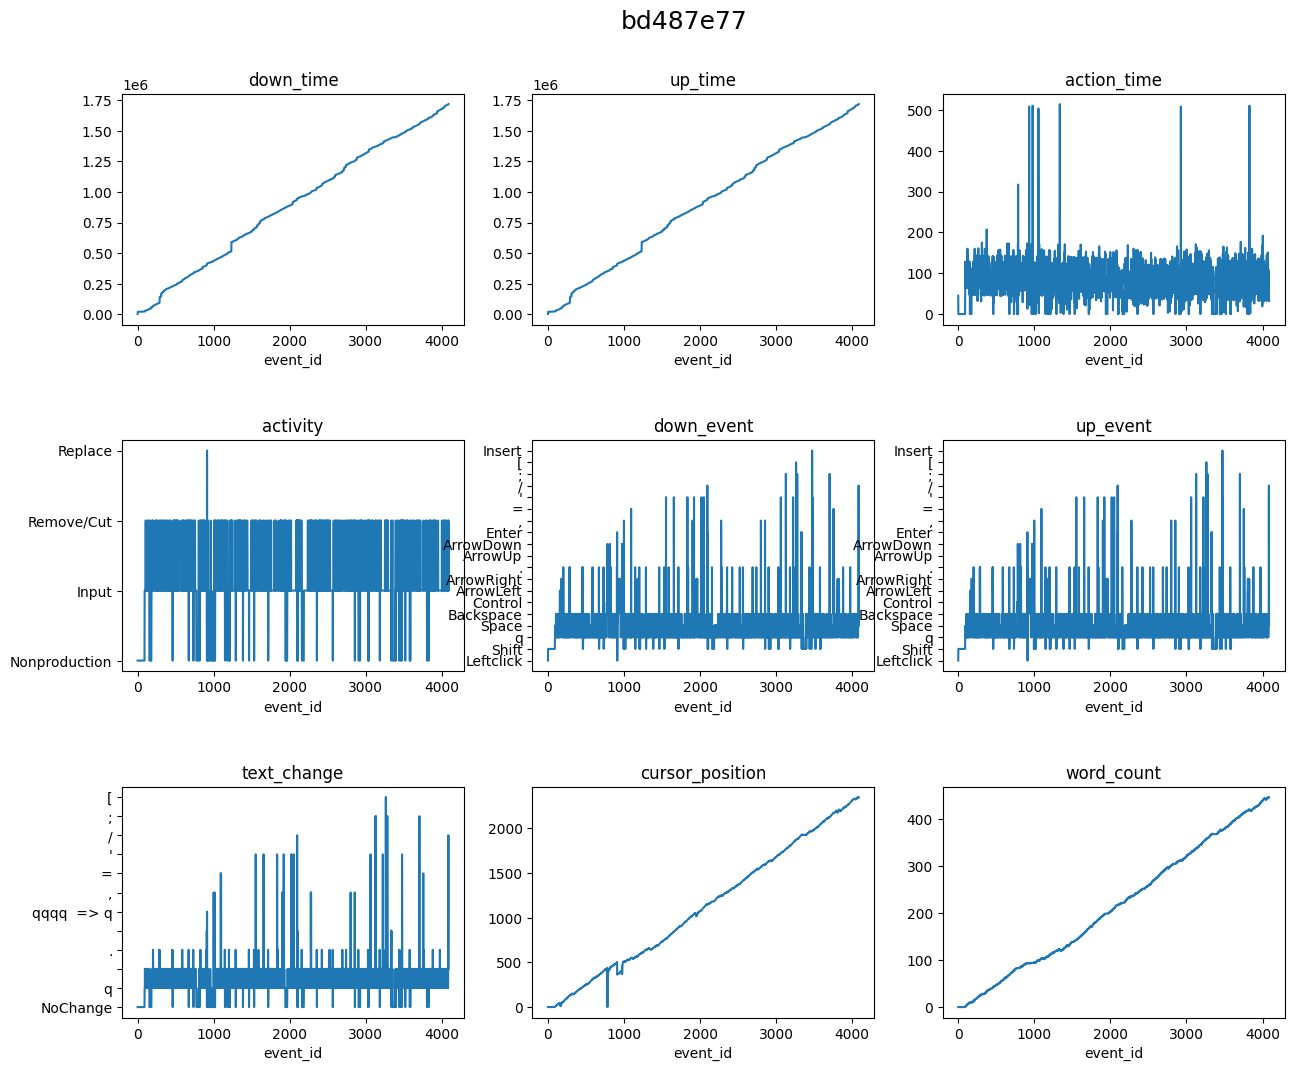

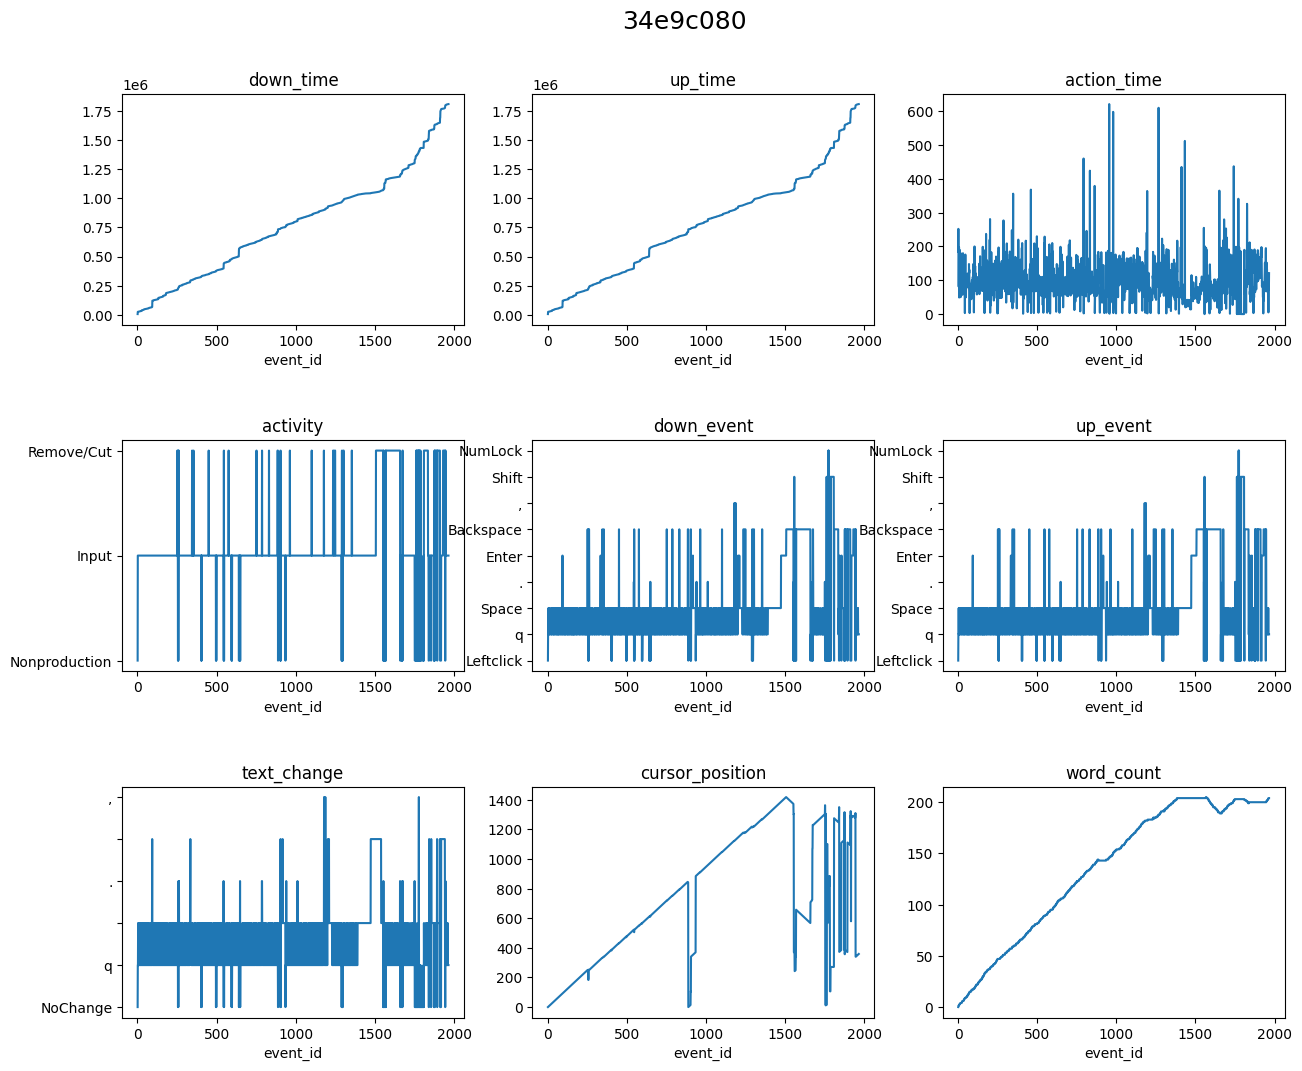

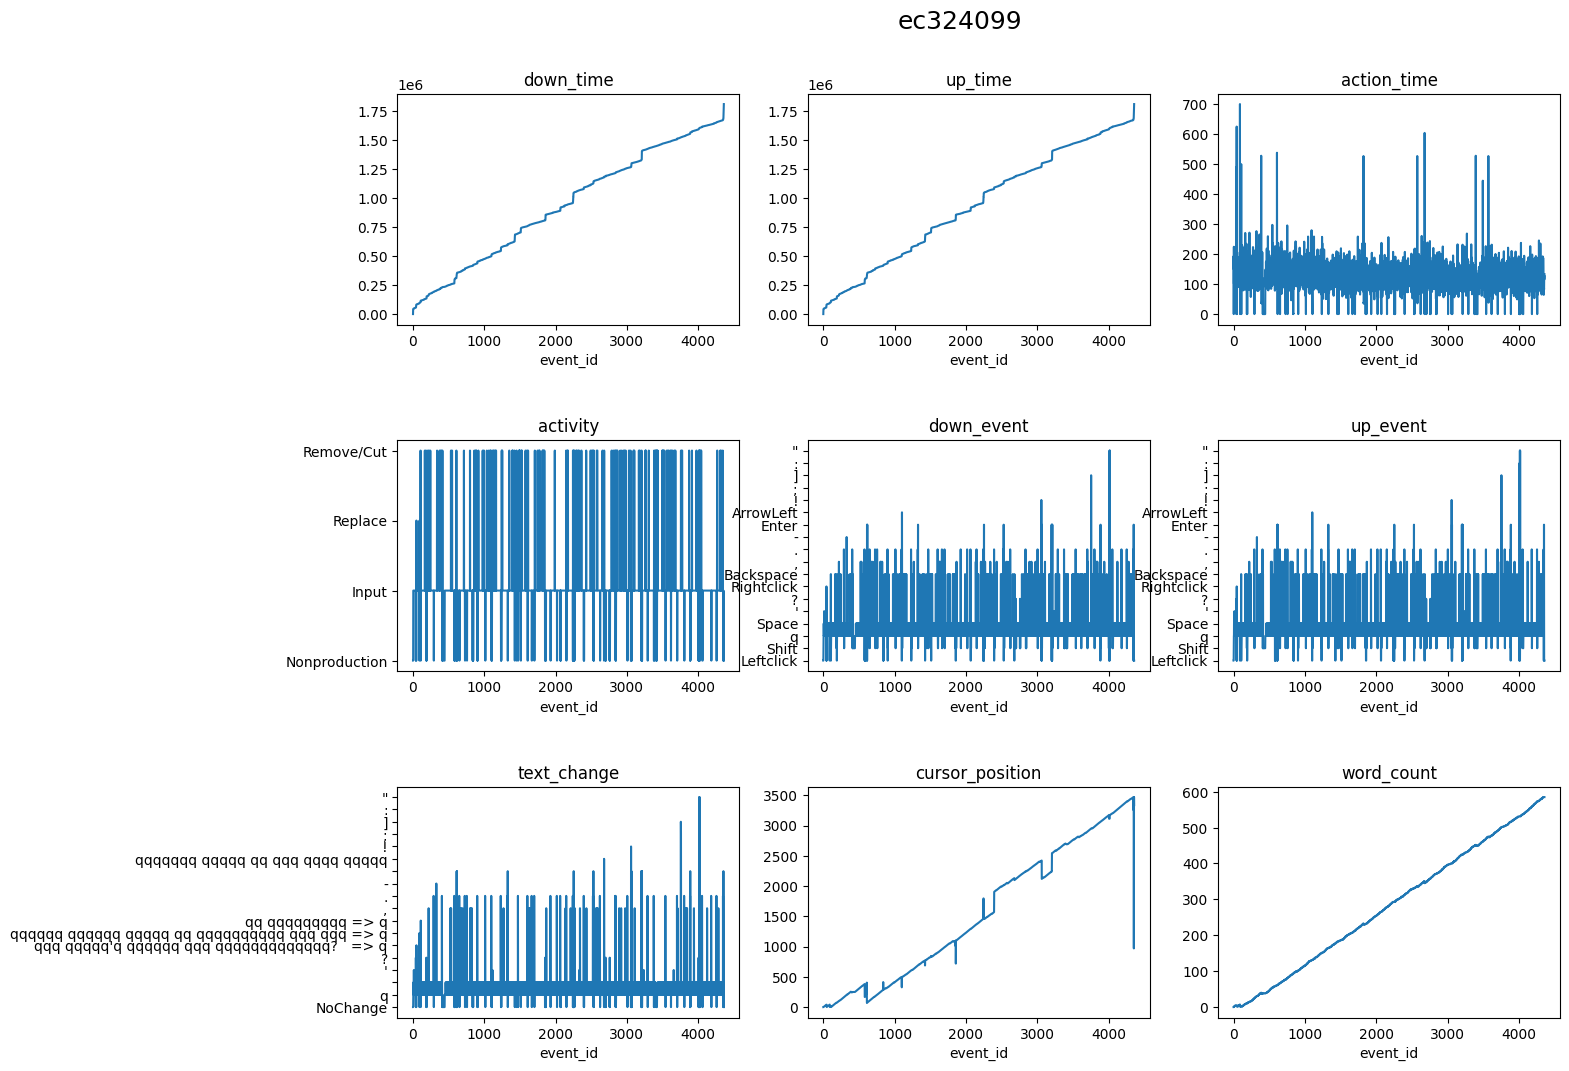

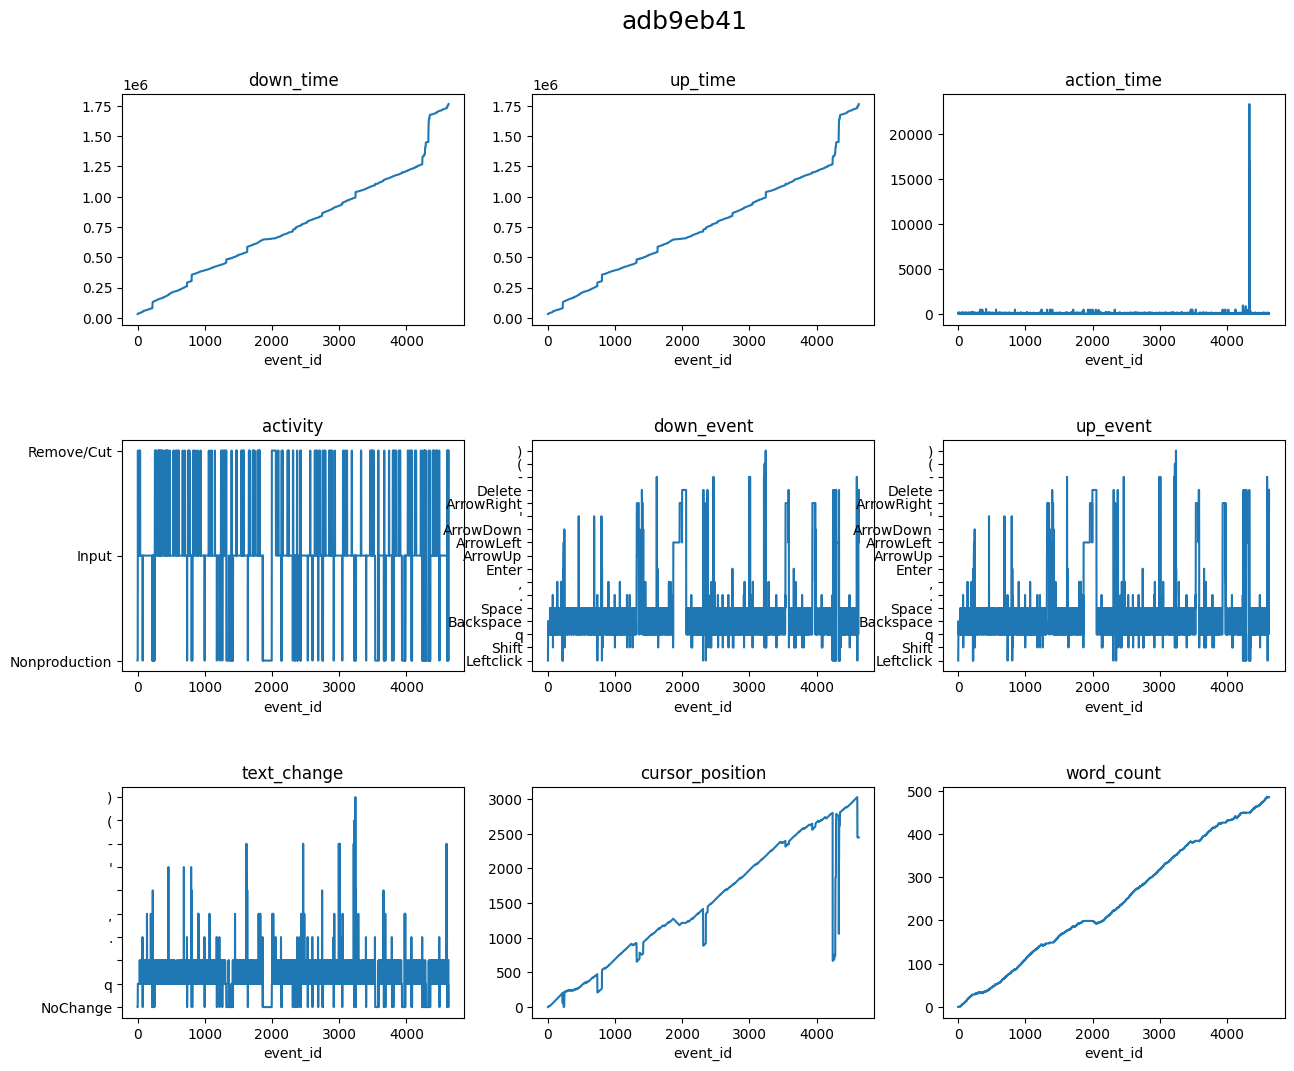

In [18]:
for i in range(5):
    sample = grpd_df.sample(1).iloc[0]
    plot_all_timeseries_events(sample)

## Understanding Text Change Event #####

In [19]:
train_logs_df.text_change.nunique()

4111

In [20]:
train_logs_df.text_change.value_counts()

text_change
q                                                                                                                                                               6128208
                                                                                                                                                                1376829
NoChange                                                                                                                                                         703851
.                                                                                                                                                                 67797
,                                                                                                                                                                 54797
                                                                                                                                                    

### Make timeseries of same length ###

In [21]:
max_length = 15000

In [22]:
grpd_df

id                                           event_id  \
0     001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1     0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2     0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3     0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4     0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
...        ...                                                ...   
2466  ffb8c745  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2467  ffbef7e5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2468  ffccd6fd  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2469  ffec5b38  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2470  fff05981  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              down_time  \
0     [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1     [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2     [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3     [41395, 143203, 147422, 147627, 147655, 147687...   
4     [78470, 94232, 94454, 94795, 94963, 95232, 954...   
...                                                 ...   
2466  [22467, 25872, 27177, 28030, 28243, 28489, 287...   
2467  [21732, 33464, 40410, 40574, 41148, 41352, 419...   
2468  [23482, 36169, 39919, 40174, 40435, 40851, 410...   
2469  [19885, 27561, 27617, 27861, 28027, 28112, 282...   
2470  [39727, 56401, 76584, 76750, 76854, 77030, 771...   

                                                up_time  \
0     [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1     [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2     [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3     [41513, 143261, 147422, 147627, 147655, 147687...   
4     [78693, 94232, 94617, 95006, 95149, 95359, 956...   
...                                                 ...   
2466  [22551, 25872, 27286, 28129, 28324, 28597, 288...   
2467  [22027, 33609, 40410, 40726, 41241, 41463, 419...   
2468  [23570, 36280, 40015, 40270, 40579, 40945, 411...   
2469  [20088, 27561, 27729, 27951, 28098, 28261, 283...   
2470  [39880, 56487, 76719, 76862, 76959, 77207, 772...   

                                            action_time  \
0     [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1     [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2     [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3     [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   
...                                                 ...   
2466  [84, 0, 109, 99, 81, 108, 102, 110, 0, 101, 12...   
2467  [295, 145, 0, 152, 93, 111, 82, 74, 56, 104, 7...   
2468  [88, 111, 96, 96, 144, 94, 93, 126, 69, 127, 1...   
2469  [203, 0, 112, 90, 71, 149, 98, 99, 105, 100, 9...   
2470  [153, 86, 135, 112, 105, 177, 137, 152, 136, 1...   

                                               activity  \
0     [Nonproduction, Nonproduction, Nonproduction, ...   
1     [Nonproduction, Nonproduction, Input, Input, I...   
2     [Nonproduction, Nonproduction, Input, Input, I...   
3     [Nonproduction, Nonproduction, Nonproduction, ...   
4     [Nonproduction, Nonproduction, Input, Input, I...   
...                                                 ...   
2466  [Nonproduction, Nonproduction, Nonproduction, ...   
2467  [Nonproduction, Nonproduction, Nonproduction, ...   
2468  [Nonproduction, Nonproduction, Input, Input, I...   
2469  [Nonproduction, Nonproduction, Input, Input, I...   
2470  [Nonproduction, Nonproduction, Input, Input, I...   

                                             down_event  \
0     [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1     [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2     [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3     [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4     [Leftclick, Shift, q, q, q, q, q, q, q, q, q, 

<Axes: >

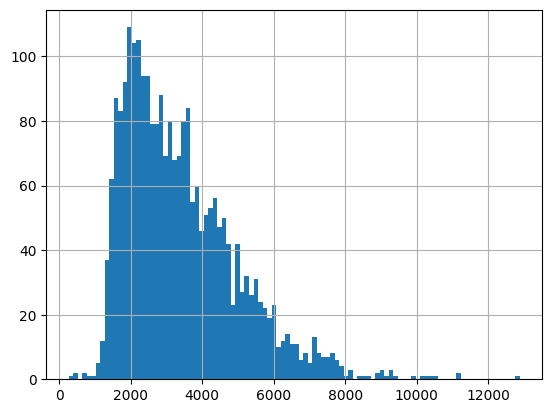

In [23]:
grpd_df.num_events.hist(bins=100)

In [24]:
train_logs_df

id  event_id  down_time  up_time  action_time       activity  \
0        001519c8         1       4526     4557           31  Nonproduction   
1        001519c8         2       4558     4962          404  Nonproduction   
2        001519c8         3     106571   106571            0  Nonproduction   
3        001519c8         4     106686   106777           91          Input   
4        001519c8         5     107196   107323          127          Input   
...           ...       ...        ...      ...          ...            ...   
8405893  fff05981      3615    2063944  2064440          496  Nonproduction   
8405894  fff05981      3616    2064497  2064497            0  Nonproduction   
8405895  fff05981      3617    2064657  2064765          108        Replace   
8405896  fff05981      3618    2069186  2069259           73  Nonproduction   
8405897  fff05981      3619    2070065  2070133           68          Input   

        down_event   up_event text_change  cursor_position  word_count  
0        Leftclick  Leftclick    NoChange                0           0  
1        Leftclick  Leftclick    NoChange                0           0  
2            Shift      Shift    NoChange                0           0  
3                q          q           q                1           1  
4                q          q           q                2           1  
...            ...        ...         ...              ...         ...  
8405893  Leftclick  Leftclick    NoChange             1031         240  
8405894      Shift      Shift    NoChange             1031         240  
8405895          q          q      q => q             1031         240  
8405896  Leftclick  Leftclick    NoChange             1028         240  
8405897          .          .           .             1029         240  

[8405898 rows x 11 columns]

<Axes: >

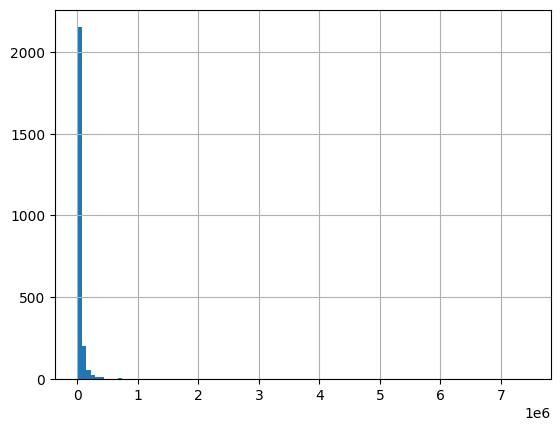

In [25]:
train_logs_df[train_logs_df.event_id == 1].down_time.hist(bins=100)

In [26]:
def is_strictly_increasing(my_list):
    if all(i <= j for i, j in zip(my_list, my_list[1:])):
        return True
    else:
        return False

In [27]:
grpd_df.down_time.apply(lambda x: is_strictly_increasing(x)).value_counts()

down_time
True     2470
False       1
Name: count, dtype: int64

In [28]:
grpd_df.up_time.apply(lambda x: is_strictly_increasing(x)).value_counts()

up_time
False    2213
True      258
Name: count, dtype: int64

In [29]:
grpd_df["is_down_time_increasing"] = grpd_df.down_time.apply(
    lambda x: is_strictly_increasing(x)
)
grpd_df["is_up_time_increasing"] = grpd_df.up_time.apply(
    lambda x: is_strictly_increasing(x)
)

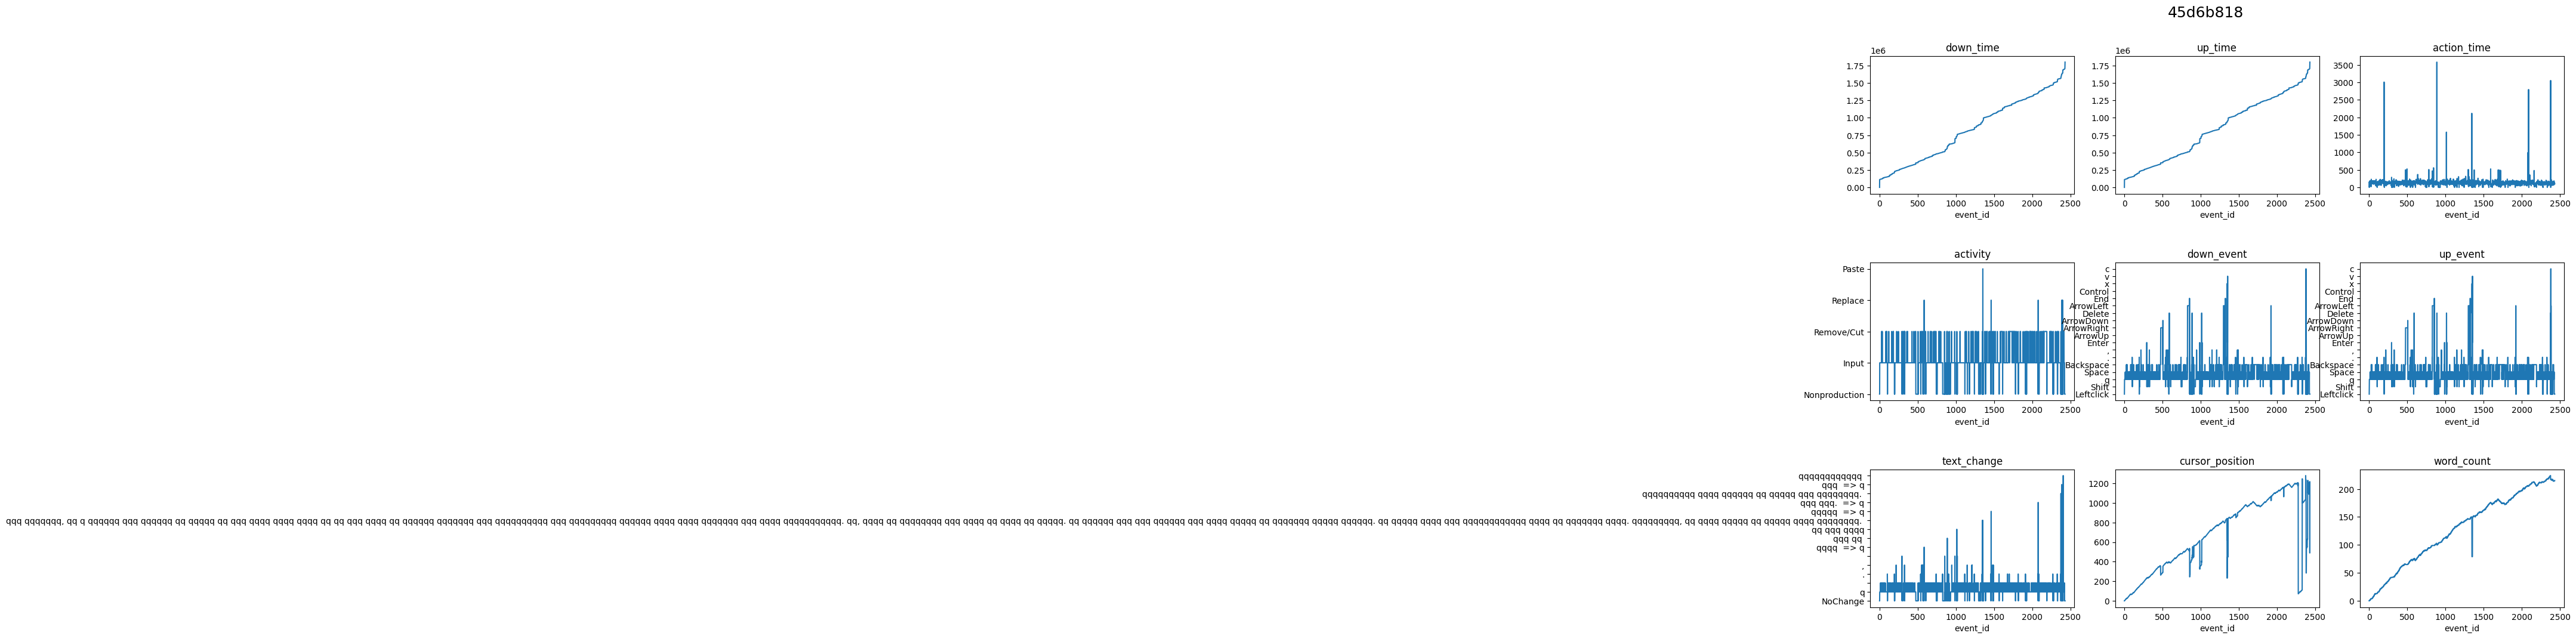

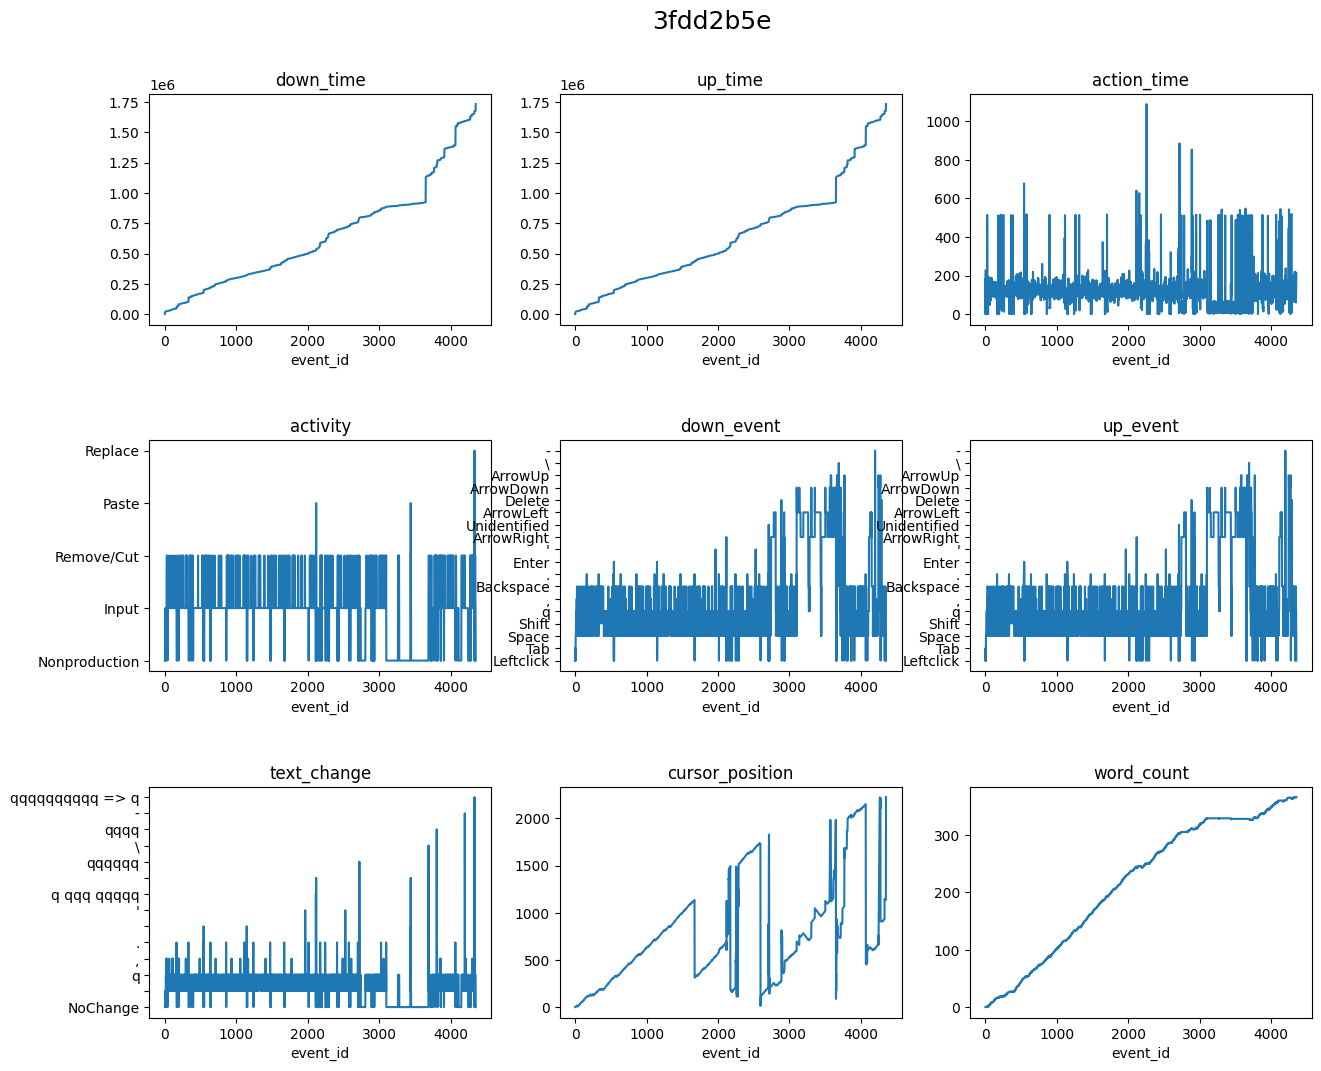

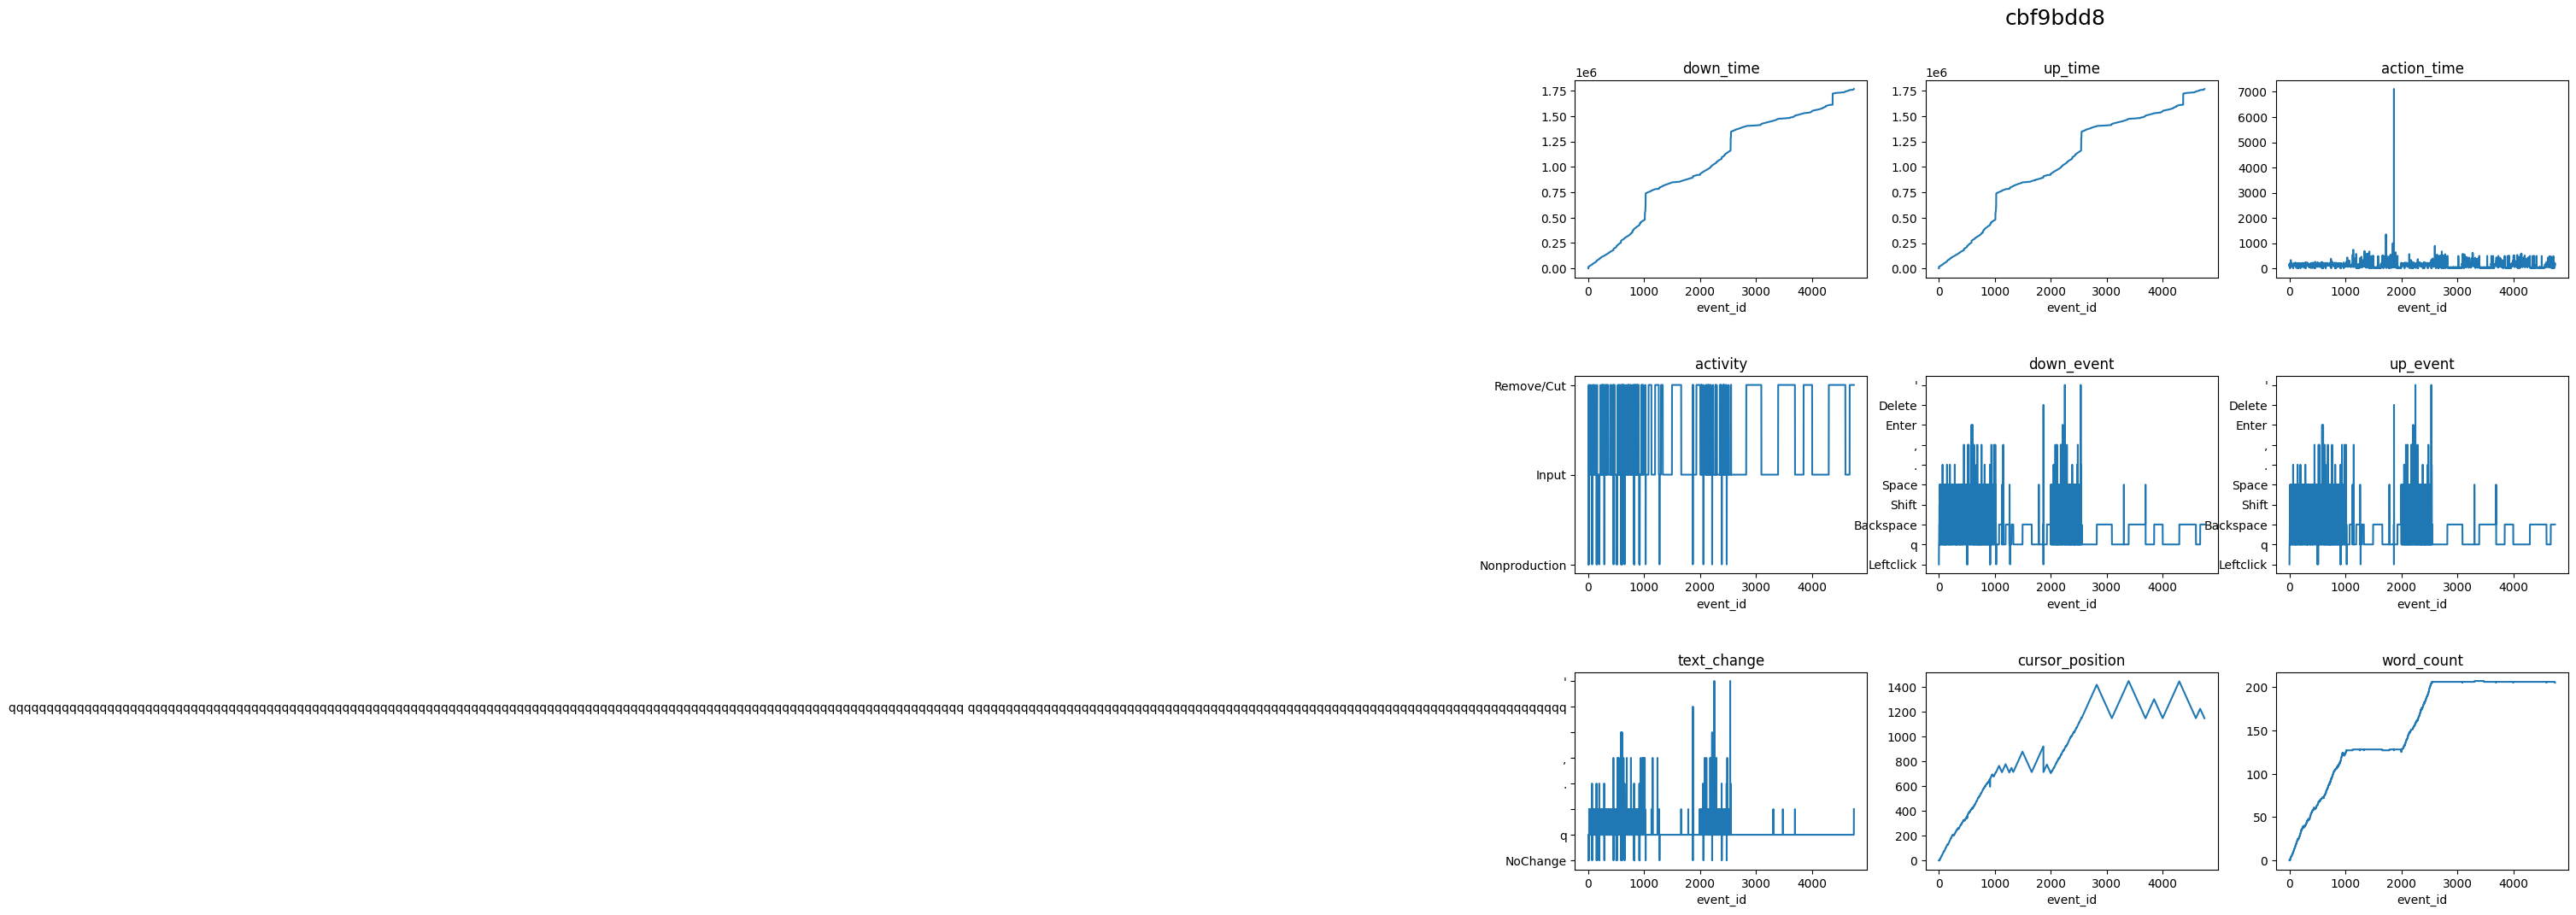

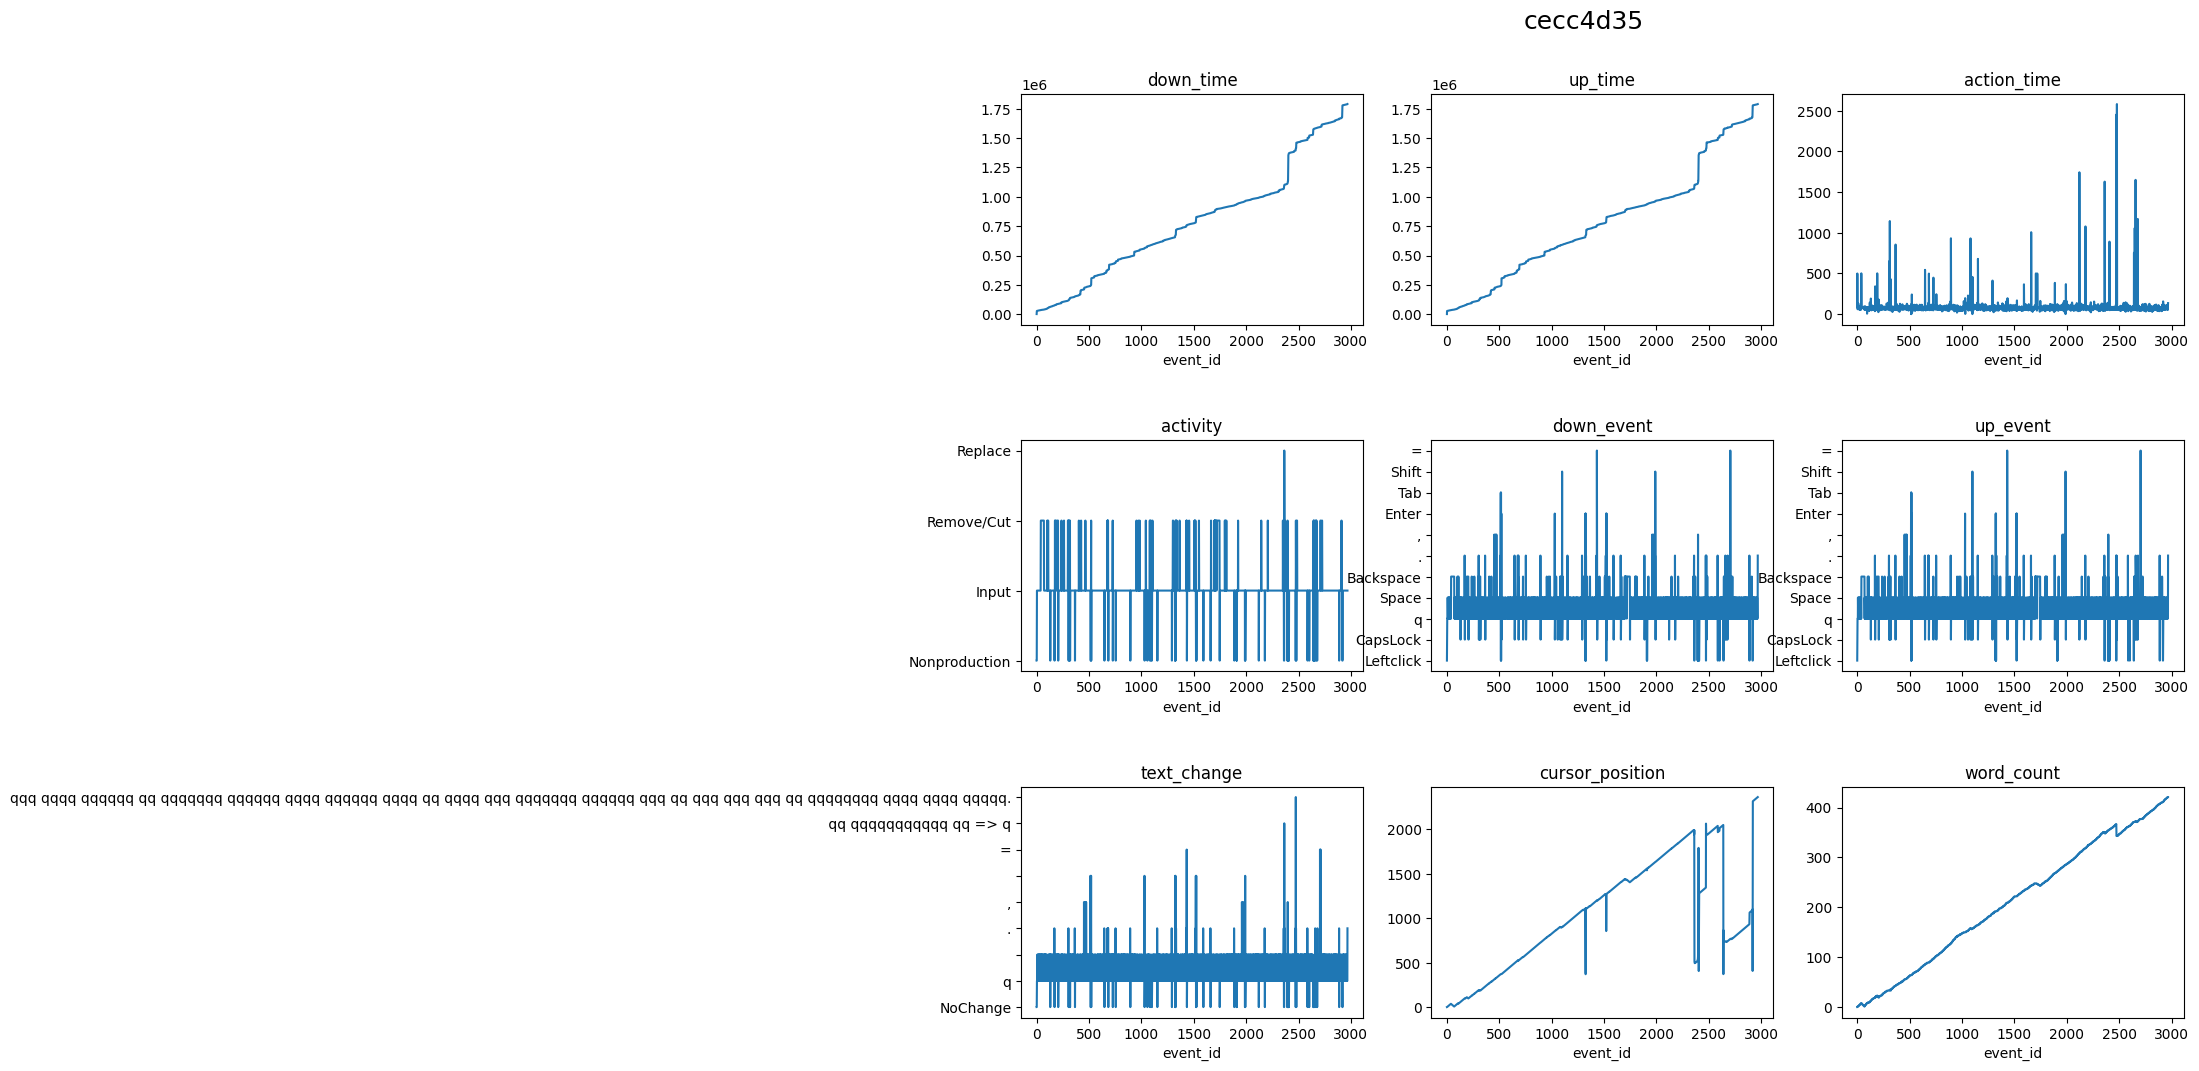

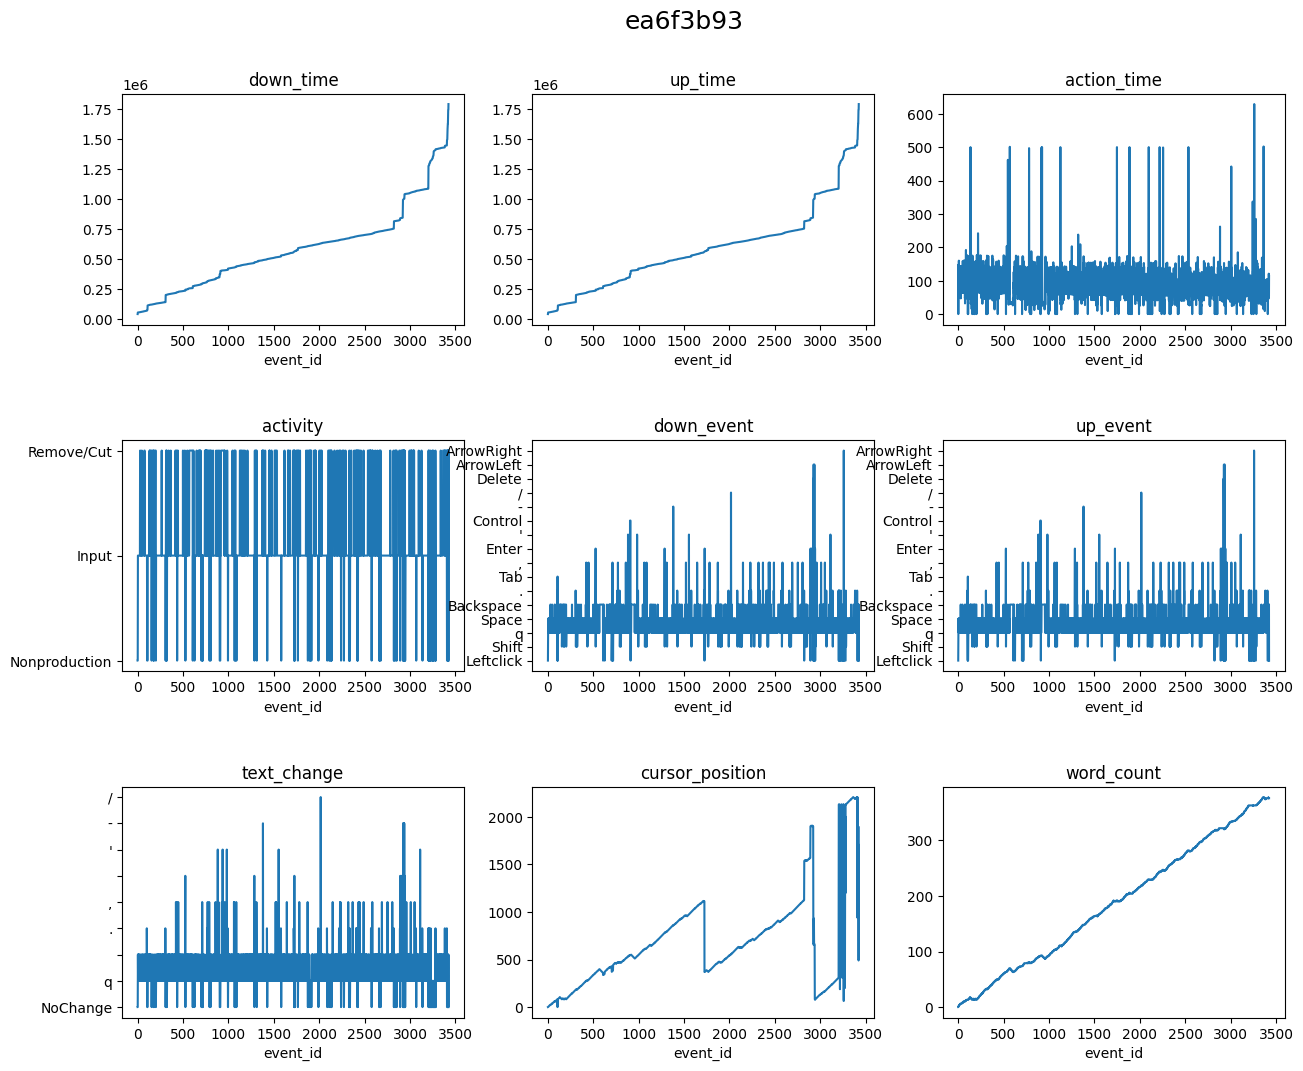

In [30]:
for i in range(5):
    sample = grpd_df[~grpd_df.is_up_time_increasing].sample(1).iloc[0]
    plot_all_timeseries_events(sample)

In [31]:
train_logs_df[train_logs_df.activity == "Paste"]

id  event_id  down_time  up_time  action_time activity  \
4797     0022f953      2241    1017354  1017425           71    Paste   
9365     0059420b       219     285459   285619          160    Paste   
41276    00fc9a6a      1601     737215   737552          337    Paste   
41987    00fc9a6a      2312    1129516  1129835          319    Paste   
46948    014e7ae9      2455     828133   828256          123    Paste   
...           ...       ...        ...      ...          ...      ...   
8372799  ff635a91       309     135266   135398          132    Paste   
8374400  ff635a91      1910    1014489  1014642          153    Paste   
8374465  ff635a91      1975    1031024  1031142          118    Paste   
8374710  ff635a91      2220    1335273  1335382          109    Paste   
8402913  fff05981       635     441084   441172           88    Paste   

        down_event up_event  \
4797         Space    Space   
9365             v        v   
41276            v        v   
41987            z        z   
46948            v        v   
...            ...      ...   
8372799          v        v   
8374400          v        v   
8374465          v        v   
8374710      Space    Space   
8402913          v        v   

                                               text_change  cursor_position  \
4797                                                   \n               696   
9365                                          qqqqqqqqqqq                95   
41276    qqqqqq qqqqqqq qqqqqq qqq qq qqqqqqqqqq qqq qq...               78   
41987                                      qq qqqqqq qqqq,              980   
46948    qqq qqqqqq qqq qqqq qqqqqqqqqqq qq qqq qqqqq q...             1601   
...                                                    ...              ...   
8372799               qqqqqqqqq qqqqqqq qqq qqqqqqqqq qqqq              278   
8374400                                        qqqqqqqqqqq             1443   
8374465                                        qqqqqqqqqqq             1490   
8374710                                        qqqqqqqqqqq              660   
8402913                                            qqqqqqq               15   

         word_count  
4797            316  
9365             23  
41276           153  
41987           230  
46948           280  
...             ...  
8372799          44  
8374400         248  
8374465         255  
8374710         287  
8402913          29  

[599 rows x 11 columns]

In [32]:
train_logs_df[train_logs_df.activity == "Paste"].down_event.value_counts()

down_event
v             269
Space         180
Rightclick     50
z              25
s              17
t              13
r               9
i               7
n               5
e               4
a               4
V               3
d               2
h               2
o               2
Enter           1
.               1
S               1
c               1
u               1
p               1
m               1
Name: count, dtype: int64

In [33]:
train_logs_df[train_logs_df.activity == "Replace"].down_event.value_counts()

down_event
q             3923
Space          242
.               80
,               51
z               36
v               22
Enter           22
Rightclick      12
"               11
-                8
=                7
\                7
;                6
?                4
/                3
Leftclick        3
'                2
[                2
:                2
t                1
V                1
!                1
]                1
(                1
Name: count, dtype: int64

In [34]:
train_logs_df[
    train_logs_df.down_event != train_logs_df.up_event
].up_event.value_counts()

up_event
t     100
i      76
w      60
a      57
m      41
c      29
s      28
o      24
h      18
f      15
p      15
b      15
e       8
g       7
l       7
Ä±      7
r       6
n       5
j       4
y       3
d       3
v       2
A       2
u       1
k       1
Name: count, dtype: int64

In [35]:
train_logs_df.up_event.value_counts()

up_event
q             5364789
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
               ...   
Cancel              1
T                   1
S                   1
M                   1
F6                  1
Name: count, Length: 130, dtype: int64

In [36]:
train_logs_df.down_event.value_counts()

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
               ...   
F10                 1
Cancel              1
S                   1
T                   1
F6                  1
Name: count, Length: 131, dtype: int64

In [37]:
train_logs_df[train_logs_df.activity == "Remove/Cut"].down_event.value_counts()

down_event
Backspace     959230
Delete         10636
x                124
z                 92
Rightclick        76
Name: count, dtype: int64

In [38]:
train_logs_df[train_logs_df.activity == "Nonproduction"].down_event.value_counts()

down_event
Shift         334227
ArrowRight    121338
Leftclick      91081
ArrowLeft      63217
ArrowDown      30874
               ...  
F10                1
T                  1
Cancel             1
j                  1
`                  1
Name: count, Length: 94, dtype: int64

In [39]:
tmp_df = (
    train_logs_df[train_logs_df.activity == "Nonproduction"]
    .down_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"})
)
tmp_df

down_event  num_events
0        Shift      334227
1   ArrowRight      121338
2    Leftclick       91081
3    ArrowLeft       63217
4    ArrowDown       30874
..         ...         ...
89         F10           1
90           T           1
91      Cancel           1
92           j           1
93           `           1

[94 rows x 2 columns]

In [40]:
tmp_df.num_events.describe()

count        94.000000
mean       7487.776596
std       38163.001847
min           1.000000
25%           3.000000
50%          11.500000
75%         143.500000
max      334227.000000
Name: num_events, dtype: float64

In [41]:
tmp_df[tmp_df.num_events > 100].down_event.unique()

array(['Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', 'ArrowDown',
       'ArrowUp', 'CapsLock', 'Unidentified', 'Control', 'Backspace',
       'Tab', 'ContextMenu', 'End', 'Rightclick', 'Meta', 'Alt', 'c',
       'Delete', 'NumLock', 'Insert', 'Home', 'Space', 'AudioVolumeDown',
       'F2', 'a', 'AudioVolumeUp'], dtype=object)

In [42]:
fig = px.bar(
    train_logs_df[train_logs_df.activity == "Nonproduction"]
    .down_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"}),
    x="down_event",
    y="num_events",
)
fig.show()

In [43]:
train_logs_df[train_logs_df.activity == "Input"].down_event.value_counts()

down_event
q        5361396
Space    1206512
.          59496
,          46752
Enter      22655
'          11166
"           4091
-           3832
?           3151
;           1778
=           1142
/            868
:            632
(            610
)            578
\            547
!            545
[            367
$             97
>             89
]             80
*             69
%             65
&             60
<             34
+             28
z             26
_             20
{             18
`             17
#             17
             14
@             13
â            4
}              4
~              4
Ä±             3
|              3
^              2
¿              2
              2
              1
Å             1
Â´             1
              1
¡              1
Ë             1
ä              1
Name: count, dtype: int64

In [44]:
fig = px.bar(
    train_logs_df.down_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"}),
    x="down_event",
    y="num_events",
)
fig.show()

In [45]:
train_logs_df.groupby("id").down_time.shift(1)

0                NaN
1             4526.0
2             4558.0
3           106571.0
4           106686.0
             ...    
8405893    2062417.0
8405894    2063944.0
8405895    2064497.0
8405896    2064657.0
8405897    2069186.0
Name: down_time, Length: 8405898, dtype: float64

In [46]:
grpd_df[~grpd_df["is_up_time_increasing"]]

id                                           event_id  \
0     001519c8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1     0022f953  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2     0042269b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3     0059420b  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4     0075873a  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
...        ...                                                ...   
2463  ff9a11ae  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2466  ffb8c745  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2468  ffccd6fd  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2469  ffec5b38  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2470  fff05981  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              down_time  \
0     [4526, 4558, 106571, 106686, 107196, 107296, 1...   
1     [30623, 32549, 32706, 32826, 32922, 33010, 331...   
2     [4441, 21276, 21335, 21533, 21594, 21692, 2174...   
3     [41395, 143203, 147422, 147627, 147655, 147687...   
4     [78470, 94232, 94454, 94795, 94963, 95232, 954...   
...                                                 ...   
2463  [64512, 66571, 66966, 69414, 69531, 69638, 701...   
2466  [22467, 25872, 27177, 28030, 28243, 28489, 287...   
2468  [23482, 36169, 39919, 40174, 40435, 40851, 410...   
2469  [19885, 27561, 27617, 27861, 28027, 28112, 282...   
2470  [39727, 56401, 76584, 76750, 76854, 77030, 771...   

                                                up_time  \
0     [4557, 4962, 106571, 106777, 107323, 107400, 1...   
1     [30853, 32549, 32842, 32946, 33050, 33130, 333...   
2     [4540, 21276, 21430, 21665, 21742, 21832, 2187...   
3     [41513, 143261, 147422, 147627, 147655, 147687...   
4     [78693, 94232, 94617, 95006, 95149, 95359, 956...   
...                                                 ...   
2463  [64637, 66571, 67106, 69568, 69663, 69802, 702...   
2466  [22551, 25872, 27286, 28129, 28324, 28597, 288...   
2468  [23570, 36280, 40015, 40270, 40579, 40945, 411...   
2469  [20088, 27561, 27729, 27951, 28098, 28261, 283...   
2470  [39880, 56487, 76719, 76862, 76959, 77207, 772...   

                                            action_time  \
0     [31, 404, 0, 91, 127, 104, 127, 107, 109, 138,...   
1     [230, 0, 136, 120, 128, 120, 224, 144, 160, 14...   
2     [99, 0, 95, 132, 148, 140, 128, 121, 103, 62, ...   
3     [118, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [223, 0, 163, 211, 186, 127, 190, 185, 168, 16...   
...                                                 ...   
2463  [125, 0, 140, 154, 132, 164, 150, 111, 117, 94...   
2466  [84, 0, 109, 99, 81, 108, 102, 110, 0, 101, 12...   
2468  [88, 111, 96, 96, 144, 94, 93, 126, 69, 127, 1...   
2469  [203, 0, 112, 90, 71, 149, 98, 99, 105, 100, 9...   
2470  [153, 86, 135, 112, 105, 177, 137, 152, 136, 1...   

                                               activity  \
0     [Nonproduction, Nonproduction, Nonproduction, ...   
1     [Nonproduction, Nonproduction, Input, Input, I...   
2     [Nonproduction, Nonproduction, Input, Input, I...   
3     [Nonproduction, Nonproduction, Nonproduction, ...   
4     [Nonproduction, Nonproduction, Input, Input, I...   
...                                                 ...   
2463  [Nonproduction, Nonproduction, Input, Input, I...   
2466  [Nonproduction, Nonproduction, Nonproduction, ...   
2468  [Nonproduction, Nonproduction, Input, Input, I...   
2469  [Nonproduction, Nonproduction, Input, Input, I...   
2470  [Nonproduction, Nonproduction, Input, Input, I...   

                                             down_event  \
0     [Leftclick, Leftclick, Shift, q, q, q, q, q, q...   
1     [Leftclick, Shift, q, q, q, q, Space, q, q, Sp...   
2     [Leftclick, Shift, q, q, q, q, q, q, q, Space,...   
3     [Leftclick, Leftclick, Shift, Shift, Shift, Sh...   
4     [Leftclick, Shift, q, q, q, q, q, q, q, q, q, 

In [47]:
train_logs_df[train_logs_df.down_time > train_logs_df.up_time]

Empty DataFrame
Columns: [id, event_id, down_time, up_time, action_time, activity, down_event, up_event, text_change, cursor_position, word_count]
Index: []

In [48]:
train_logs_df[
    (train_logs_df.groupby("id").up_time.shift(-1) - train_logs_df.up_time) > 0
].id.nunique()

2471

In [49]:
# train_logs_df.shape

In [50]:
tmp_df = train_logs_df[["id", "event_id", "up_time", "down_time", "action_time"]]
tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
tmp_df["up_time_next_next"] = tmp_df.groupby("id").up_time.shift(-2)
tmp_df["up_time_next_next_next"] = tmp_df.groupby("id").up_time.shift(-3)
tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

/tmp/ipykernel_5784/3023138293.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784/3023138293.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784/3023138293.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784

In [51]:
tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
    tmp_df.up_time_diff < 0
].up_time_next

In [52]:
tmp_df[tmp_df.up_time_diff < 0]

id  event_id  up_time  down_time  action_time  up_time_next  \
116      001519c8       117   163812     163714          165      163812.0   
274      001519c8       275   271107     270999          158      271107.0   
1274     001519c8      1275   891069     890938          145      891069.0   
2649     0022f953        93    63274      63090          200       63274.0   
2785     0022f953       229    96566      96486          120       96566.0   
...           ...       ...      ...        ...          ...           ...   
8399217  ffec5b38       181    69019      68809          220       69019.0   
8400668  ffec5b38      1632   575883     575759          137      575883.0   
8404157  fff05981      1879  1156385    1156315           76     1156385.0   
8405001  fff05981      2723  1598203    1598187          109     1598203.0   
8405288  fff05981      3010  1768773    1768624          229     1768773.0   

         up_time_next_next  up_time_next_next_next  up_time_diff  
116               164442.0                164584.0         -67.0  
274               271728.0                271888.0         -50.0  
1274              891350.0                891661.0         -14.0  
2649               63498.0                 64586.0         -16.0  
2785               96862.0                 96942.0         -40.0  
...                    ...                     ...           ...  
8399217            69079.0                 69171.0         -10.0  
8400668           576345.0                576869.0         -13.0  
8404157          1156551.0               1156719.0          -6.0  
8405001          1598568.0               1598915.0         -93.0  
8405288          1770141.0               1770309.0         -80.0  

[48558 rows x 9 columns]

In [53]:
tmp_df.groupby("id").agg(up_time=("up_time", list)).up_time.apply(
    lambda x: is_strictly_increasing(x)
).value_counts()

up_time
True     2153
False     318
Name: count, dtype: int64

In [54]:
tmp_df = tmp_df[["id", "event_id", "up_time", "down_time", "action_time"]]
tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
    tmp_df.up_time_diff < 0
].up_time_next
tmp_df.groupby("id").agg(up_time=("up_time", list)).up_time.apply(
    lambda x: is_strictly_increasing(x)
).value_counts()

up_time
True     2446
False      25
Name: count, dtype: int64

In [55]:
tmp_df = tmp_df[["id", "event_id", "up_time", "down_time", "action_time"]]
tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
    tmp_df.up_time_diff < 0
].up_time_next
tmp_df.groupby("id").agg(up_time=("up_time", list)).up_time.apply(
    lambda x: is_strictly_increasing(x)
).value_counts()

up_time
True     2464
False       7
Name: count, dtype: int64

In [56]:
tmp_df[tmp_df.down_time > tmp_df.up_time]

id  event_id  up_time  down_time  action_time  up_time_next  \
5136534  a0c24719        66    17967      60166          130       17967.0   
5136535  a0c24719        67    17967      64594          141       17967.0   
5136536  a0c24719        68    17967      66231          106       17967.0   

         up_time_diff  
5136534      -42329.0  
5136535           0.0  
5136536           0.0

In [57]:
tmp_df[tmp_df.id == "a0c24719"]

id  event_id  up_time  down_time  action_time  up_time_next  \
5136469  a0c24719         1     1920       1693          227       33471.0   
5136470  a0c24719         2    33471      33471            0       33792.0   
5136471  a0c24719         3    33792      33683          109       35546.0   
5136472  a0c24719         4    35546      35452           94       35877.0   
5136473  a0c24719         5    35877      35778           99       35958.0   
...           ...       ...      ...        ...          ...           ...   
5140681  a0c24719      4213  1930908    1930302          861     1930908.0   
5140682  a0c24719      4214  1930908    1930908            0     1931972.0   
5140683  a0c24719      4215  1931972    1931894           78     1935064.0   
5140684  a0c24719      4216  1935064    1934178          886     1936327.0   
5140685  a0c24719      4217  1936327    1936239           88           NaN   

         up_time_diff  
5136469       31551.0  
5136470         321.0  
5136471        1754.0  
5136472         331.0  
5136473          81.0  
...               ...  
5140681           0.0  
5140682        1064.0  
5140683        3092.0  
5140684        1263.0  
5140685           NaN  

[4217 rows x 7 columns]

In [58]:
tmp_df[tmp_df.up_time_diff < 0].up_time_diff.describe()

count       54.000000
mean      -833.666667
std       5754.129903
min     -42329.000000
25%        -52.500000
50%        -19.000000
75%        -11.000000
max         -1.000000
Name: up_time_diff, dtype: float64

In [59]:
tmp_df[tmp_df.up_time_diff == -327671]

Empty DataFrame
Columns: [id, event_id, up_time, down_time, action_time, up_time_next, up_time_diff]
Index: []

In [60]:
tmp_df.groupby("id").up_time.shift(-1)

0             4962.0
1           106571.0
2           106777.0
3           107323.0
4           107400.0
             ...    
8405893    2064497.0
8405894    2064765.0
8405895    2069259.0
8405896    2070133.0
8405897          NaN
Name: up_time, Length: 8405898, dtype: float64

In [61]:
tmp_df[tmp_df.up_time_diff < 0]

id  event_id  up_time  down_time  action_time  up_time_next  \
590938   11c44718       876   682987     682896          104      682987.0   
738595   153aafba      1703   707984     707926          112      707984.0   
738600   153aafba      1708   708639     708503          186      708639.0   
1080781  20ffdd91      2041  1329290    1329122          233     1329290.0   
1081869  20ffdd91      3129  1396728    1396071         1306     1396728.0   
1084644  20ffdd91      5904  1612712    1612544          177     1612712.0   
1084665  20ffdd91      5925  1614378    1614194          198     1614378.0   
1084682  20ffdd91      5942  1616170    1615994          183     1616170.0   
1084697  20ffdd91      5957  1617509    1617373          163     1617509.0   
1085895  20ffdd91      7155  1702914    1702468          558     1702914.0   
1234664  257fb4a6      2108   808820     808611          241      808820.0   
1402525  2c3a98ab      2107  1631292    1631248           77     1631292.0   
1616742  31d5a61d        34  1094159    1093955          268     1094159.0   
2416076  4be768c3      2156  1308795    1308668          153     1308795.0   
3187842  64caebbb      2932  1556018    1555847          172     1556018.0   
3467736  6c710d22      1836  1297323    1297102          231     1297323.0   
3574688  6fe9a213      3940   659113     658967          162      659113.0   
3588866  7073cd1e      1637  1562099    1562027           89     1562099.0   
4136611  82496b31      3813  1252227    1251969          266     1252227.0   
4173707  831d0606      1157   646788     646629          170      646788.0   
4367298  874e6c1a      2470  1788533    1788279          265     1788533.0   
4367405  874e6c1a      2577  1797880    1797690          259     1797880.0   
4876308  991029d7      2561  1191056    1190805          427     1191056.0   
4876557  991029d7      2810  1342258    1342149          205     1342258.0   
4877432  991029d7      3685  1558346    1558236          370     1558346.0   
4878264  991029d7      4517  1680497    1680422           92     1680497.0   
5063308  9f1c3e52      2544   370069     369956          135      370069.0   
5136534  a0c24719        66    17967      60166          130       17967.0   
5984781  b8da9bf0      5767  1687590    1687551           49     1687590.0   
6505451  ca06574b      3745  1281468    1281291          218     1281468.0   
6505627  ca06574b      3921  1333253    1332899          451     1333253.0   
6505628  ca06574b      3922  1333196    1332969          396     1333196.0   
6505680  ca06574b      3974  1357884    1357653          303     1357884.0   
6505982  ca06574b      4276  1475837    1475667          290     1475837.0   
6506027  ca06574b      4321  1478714    1478645          145     1478714.0   
6506157  ca06574b      4451  1553295    1553121          183     1553295.0   
6506415  ca06574b      4709  1640135    1639966          184     1640135.0   
6506595  ca06574b      4889  1711067    1710968          159     1711067.0   
6506675  ca06574b      4969  1716698    1716585          147     1716698.0   
6506816  ca06574b      5110  1730472    1730360          346     1730472.0   
6506848  ca06574b      5142  1734021    1733891          179     1734021.0   
6506858  ca06574b      5152  1734710    1734594          268     1734710.0   
6506944  ca06574b      5238  1744174    1744087          209     1744174.0   
7134688  db1f9df0      5360  1645591    1645469          171     1645591.0   
7134731  db1f9df0      5403  1647648    1647526          132     1647648.0   
7134769  db1f9df0      5441  1649327    1649233          143     1649327.0   
7134883  db1f9df0      5555  1657447    1657398          153     1657447.0   
7514481  e5f9bc63        29   246317     246155          630      246317.0   
7514494  e5f9bc63        42   247232     247081          327      247232.0   
7652721  ea735e2d      1973  1026801    1026770           42     1026801.0   
7652811  ea735e2d      2063  1038260 

In [62]:
# tmp_df.up_time_diff.boxplot()

<Axes: >

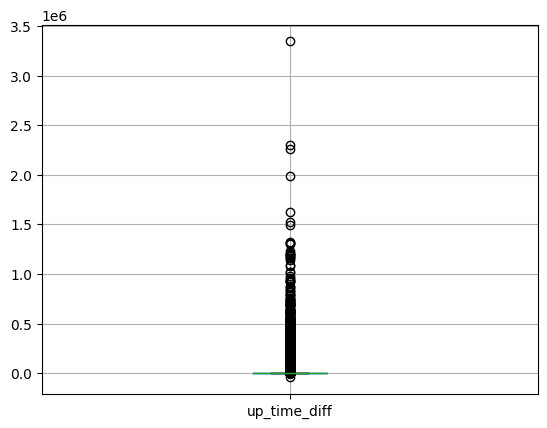

In [63]:
tmp_df.boxplot(column=["up_time_diff"])

In [64]:
tmp_df = train_logs_df[["id", "event_id", "up_time", "down_time", "action_time"]]

tmp_df["HL"] = tmp_df["up_time"] - tmp_df["down_time"]
tmp_df["IL"] = tmp_df.groupby("id").down_time.shift(-1) - tmp_df["up_time"]
tmp_df["PL"] = tmp_df.groupby("id").down_time.shift(-1) - tmp_df["down_time"]
tmp_df["RL"] = tmp_df.groupby("id").up_time.shift(-1) - tmp_df["up_time"]

/tmp/ipykernel_5784/3550647529.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784/3550647529.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784/3550647529.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5784

In [65]:
tmp_df.head()

id  event_id  up_time  down_time  action_time   HL        IL  \
0  001519c8         1     4557       4526           31   31       1.0   
1  001519c8         2     4962       4558          404  404  101609.0   
2  001519c8         3   106571     106571            0    0     115.0   
3  001519c8         4   106777     106686           91   91     419.0   
4  001519c8         5   107323     107196          127  127     -27.0   

         PL        RL  
0      32.0     405.0  
1  102013.0  101609.0  
2     115.0     206.0  
3     510.0     546.0  
4     100.0      77.0

In [66]:
tmp_df[tmp_df.action_time != tmp_df.HL]

Empty DataFrame
Columns: [id, event_id, up_time, down_time, action_time, HL, IL, PL, RL]
Index: []

In [67]:
tmp_df[tmp_df.IL < 0].IL.describe()

count    1.834576e+06
mean    -3.910497e+01
std      3.247901e+02
min     -3.277300e+05
25%     -5.400000e+01
50%     -3.100000e+01
75%     -1.400000e+01
max     -1.000000e+00
Name: IL, dtype: float64

In [68]:
tmp_df[tmp_df.isna().any(axis=1)]

id  event_id  up_time  down_time  action_time   HL  IL  PL  RL
2556     001519c8      2557  1801969    1801877           92   92 NaN NaN NaN
5010     0022f953      2454  1788969    1788842          127  127 NaN NaN NaN
9146     0042269b      4136  1771669    1771219          450  450 NaN NaN NaN
10702    0059420b      1556  1404469    1404394           75   75 NaN NaN NaN
13233    0075873a      2531  1662472    1662390           82   82 NaN NaN NaN
...           ...       ...      ...        ...          ...  ...  ..  ..  ..
8393369  ffb8c745      4739  1791649    1791581           68   68 NaN NaN NaN
8395973  ffbef7e5      2604  1799174    1799124           50   50 NaN NaN NaN
8399036  ffccd6fd      3063  1959363    1959273           90   90 NaN NaN NaN
8402278  ffec5b38      3242  1508504    1508335          169  169 NaN NaN NaN
8405897  fff05981      3619  2070133    2070065           68   68 NaN NaN NaN

[2471 rows x 9 columns]

In [69]:
train_logs_df.activity.apply(lambda x: x if x in ["Replace"] else "__OUTLIER__")

0          __OUTLIER__
1          __OUTLIER__
2          __OUTLIER__
3          __OUTLIER__
4          __OUTLIER__
              ...     
8405893    __OUTLIER__
8405894    __OUTLIER__
8405895        Replace
8405896    __OUTLIER__
8405897    __OUTLIER__
Name: activity, Length: 8405898, dtype: object

### Text change EDA ###

In [70]:
train_logs_df = pd.read_csv(cnfg.train_logs)

In [71]:
train_logs_df.text_change.nunique()

4111

In [72]:
train_logs_df.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [73]:
["Nonproduction", "Input", "Remove/Cut", "Replace", "Paste"]

['Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'Paste']

In [74]:
train_logs_df[train_logs_df.activity == "Remove/Cut"].text_change.value_counts()

text_change
q                                                                                                                                                               766788
                                                                                                                                                                170310
.                                                                                                                                                                 8301
,                                                                                                                                                                 8045
\n                                                                                                                                                                5320
                                                                                                                                                         

In [75]:
train_logs_df[train_logs_df.activity == "Nonproduction"].text_change.value_counts()

text_change
NoChange    703851
Name: count, dtype: int64

In [76]:
train_logs_df[train_logs_df.text_change == "NoChange"].activity.value_counts()

activity
Nonproduction    703851
Name: count, dtype: int64

In [77]:
train_logs_df[train_logs_df.activity == "Nonproduction"].down_event.value_counts()

down_event
Shift         334227
ArrowRight    121338
Leftclick      91081
ArrowLeft      63217
ArrowDown      30874
               ...  
F10                1
T                  1
Cancel             1
j                  1
`                  1
Name: count, Length: 94, dtype: int64

In [78]:
train_logs_df[train_logs_df.down_event == "q"].activity.value_counts()

activity
Input      5361396
Replace       3923
Name: count, dtype: int64

In [79]:
text_changes = [
    "q",
    " ",
    "NoChange",
    ".",
    ",",
    "\n",
    "'",
    '"',
    "-",
    "?",
    ";",
    "=",
    "/",
    "\\",
    ":",
]

In [80]:
for txt_chng in text_changes:
    print(f"\n*********{txt_chng}********\n")
    display(
        train_logs_df[train_logs_df.text_change == txt_chng].activity.value_counts()
    )


*********q********



activity
Input                                     5361416
Remove/Cut                                 766788
Move From [460, 461] To [465, 466]              1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [1361, 1362] To [1358, 1359]          1
Name: count, dtype: int64


********* ********



activity
Input                                 1206517
Remove/Cut                             170310
Move From [186, 187] To [184, 185]          1
Move From [164, 165] To [153, 154]          1
Name: count, dtype: int64


*********NoChange********



activity
Nonproduction    703851
Name: count, dtype: int64


*********.********



activity
Input         59496
Remove/Cut     8301
Name: count, dtype: int64


*********,********



activity
Input         46752
Remove/Cut     8045
Name: count, dtype: int64


*********
********



activity
Input                                 22656
Remove/Cut                             5320
Move From [624, 625] To [845, 846]        1
Name: count, dtype: int64


*********'********



activity
Input         11166
Remove/Cut     2026
Name: count, dtype: int64


*********"********



activity
Input         4091
Remove/Cut     568
Name: count, dtype: int64


*********-********



activity
Input         3832
Remove/Cut     660
Name: count, dtype: int64


*********?********



activity
Input         3151
Remove/Cut     356
Name: count, dtype: int64


*********;********



activity
Input         1778
Remove/Cut    1127
Name: count, dtype: int64


*********=********



activity
Remove/Cut    1146
Input         1142
Name: count, dtype: int64


*********/********



activity
Input         868
Remove/Cut    486
Name: count, dtype: int64


*********\********



activity
Remove/Cut    553
Input         547
Name: count, dtype: int64


*********:********



activity
Input         632
Remove/Cut    181
Name: count, dtype: int64

In [81]:
text_change_df = train_logs_df[train_logs_df.text_change == "q"]

In [82]:
text_change_df

id  event_id  down_time  up_time  action_time    activity  \
3        001519c8         4     106686   106777           91       Input   
4        001519c8         5     107196   107323          127       Input   
5        001519c8         6     107296   107400          104       Input   
6        001519c8         7     107469   107596          127       Input   
7        001519c8         8     107659   107766          107       Input   
...           ...       ...        ...      ...          ...         ...   
8405878  fff05981      3600    2039274  2039390          116       Input   
8405879  fff05981      3601    2039410  2039534          124       Input   
8405882  fff05981      3604    2041762  2041806           44  Remove/Cut   
8405883  fff05981      3605    2041937  2041950           13  Remove/Cut   
8405884  fff05981      3606    2042066  2042110           44  Remove/Cut   

        down_event   up_event text_change  cursor_position  word_count  
3                q          q           q                1           1  
4                q          q           q                2           1  
5                q          q           q                3           1  
6                q          q           q                4           1  
7                q          q           q                5           1  
...            ...        ...         ...              ...         ...  
8405878          q          q           q             1492         241  
8405879          q          q           q             1493         241  
8405882  Backspace  Backspace           q             1492         241  
8405883  Backspace  Backspace           q             1491         241  
8405884  Backspace  Backspace           q             1490         240  

[6128208 rows x 11 columns]

In [83]:
# text_change_df.groupby("id").agg({"text_change":list})

In [141]:
tmp_df = train_logs_df[
    (~train_logs_df["text_change"].str.contains("=>"))
    & (train_logs_df["text_change"] != "NoChange")
].reset_index(drop=True)

In [142]:
vc_tmp = (
    tmp_df.text_change.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"})
)

In [143]:
vc_tmp

text_change  num_events
0                                                     q     6128208
1                                                           1376829
2                                                     .       67797
3                                                     ,       54797
4                                                    \n       27977
...                                                 ...         ...
2279   - qq qqqq qqqqqqqq qqqq qqqqqqqqqq'q qqqqqqq ...           1
2280                                     qqqqqqqqqqq qq           1
2281  qqq qqqq qq qqqqq qqq qqqqqqqqqqqqqq qqqq qqqq...           1
2282  qq qqqq qq qqqqqqqq qqqq qqqqqqq qqqqqq, qqqqq...           1
2283  \n qqqqq qqqqqq qqqqqqqqqq qq q qqqqqqqq qqq q...           1

[2284 rows x 2 columns]

In [144]:
vc_tmp[vc_tmp.num_events > 10]

text_change  num_events
0               q     6128208
1                     1376829
2               .       67797
3               ,       54797
4              \n       27977
5               '       13192
6               "        4659
7               -        4492
8               ?        3507
9               ;        2905
10              =        2288
11              /        1354
12              \        1100
13              :         813
14              (         733
15              [         725
16              )         660
17              !         639
18              >         177
19              ]         157
20             .          137
21              $         112
22              *         108
23           qqq           90
24            qqq          83
25          qqqq           81
26           qqqq          78
27              %          77
28              &          77
29              <          67
30          qqqqq          61
31         qqqqqq          58
32             qq          55
33         qqqqq           51
34            qq           49
35        qqqqqq           41
36            \n           40
37              +          40
38        qqqqqqq          37
39              {          35
40              _          34
41              #          31
42       qqqqqqq           30
43             'q          30
44              `          30
45       qqqqqqqq          29
46              @          26
47      qqqqqqqqq          23
48      qqqqqqqq           21
49     qqqqqqqqqq          21
50     qqqqqqqqq           18
51             q           17
52  qqqqqqqqqqqqq          15
53                        14
54            qqq          13
55    qqqqqqqqqqq          12
56    qqqqqqqqqq           11

In [145]:
tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()

In [146]:
tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))

In [147]:
tmp_df.head()

id                                        text_change
0  001519c8  qqqqqq qqq qqqqqqq qqqqqq qq qqqq qqqqq qq qqq...
1  0022f953  qqqq qq qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq -  -...
2  0042269b  qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...
3  0059420b  qqqqqq qqqqqqq qqqqqq qqqqqqqqqqqqqqqqqqq qqqq...
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...

In [148]:
tmp_df["text_change2"] = tmp_df["text_change"].apply(lambda x: re.findall(r"q+", x))

In [149]:
tmp_df.head()

id                                        text_change  \
0  001519c8  qqqqqq qqq qqqqqqq qqqqqq qq qqqq qqqqq qq qqq...   
1  0022f953  qqqq qq qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq -  -...   
2  0042269b  qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...   
3  0059420b  qqqqqq qqqqqqq qqqqqq qqqqqqqqqqqqqqqqqqq qqqq...   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...   

                                        text_change2  
0  [qqqqqq, qqq, qqqqqqq, qqqqqq, qq, qqqq, qqqqq...  
1  [qqqq, qq, qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq, ...  
2  [qqqqqqq, qqq, qqqq, qqqq, qqqq, qq, qqqqqqqq,...  
3  [qqqqqq, qqqqqqq, qqqqqq, qqqqqqqqqqqqqqqqqqq,...  
4  [qqqqqqqqqqq, qq, qqq, qqqqq, qq, qqqqqqqqqq, ...

In [164]:
tmp_df2 = tmp_df[["id", "text_change2"]].explode(column="text_change2")

In [165]:
tmp_df2["word_len"] = tmp_df2.text_change2.apply(
    lambda x: "more_than_10" if len(x) > 10 else str(len(x))
)

In [167]:
tmp_df2.word_len.value_counts()

word_len
2               238539
4               227930
3               219014
5               128150
6               112853
7                83009
more_than_10     81083
1                65962
8                56464
9                46562
10               32196
Name: count, dtype: int64

In [168]:
tmp_df2.groupby("id", as_index=False).agg({"word_len": list})

id                                           word_len
0     001519c8  [6, 3, 7, 6, 2, 4, 5, 2, 4, 5, 2, 5, 5, 4, mor...
1     0022f953  [4, 2, more_than_10, 4, 2, 3, 3, 3, 7, 3, 5, 2...
2     0042269b  [7, 3, 4, 4, 4, 2, 8, 7, 7, 2, 10, more_than_1...
3     0059420b  [6, 7, 6, more_than_10, 4, 1, 4, 4, 7, 5, 3, 4...
4     0075873a  [more_than_10, 2, 3, 5, 2, 10, 3, more_than_10...
...        ...                                                ...
2466  ffb8c745  [2, 5, 1, 7, 3, 1, 5, 1, 4, 2, 3, 5, 6, 3, 4, ...
2467  ffbef7e5  [4, 6, 5, 2, 5, 5, 2, 2, 1, 5, 1, 3, 2, 8, 3, ...
2468  ffccd6fd  [6, 4, 1, 7, 8, 3, 6, 6, 2, 6, 3, 6, 9, 2, 3, ...
2469  ffec5b38  [more_than_10, 7, 6, 4, 5, 4, 7, 2, more_than_...
2470  fff05981  [2, 4, 8, 2, more_than_10, more_than_10, 2, 2,...

[2471 rows x 2 columns]

In [163]:
[x for x in range(1, 11)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
tmp_df2.groupby("id", as_index=False).agg()

In [93]:
tmp_df["input_word_count"] = tmp_df["text_change2"].apply(len)

In [94]:
tmp_df.head()

id                                        text_change  \
0  001519c8  qqqqqq qqq qqqqqqq qqqqqq qq qqqq qqqqq qq qqq...   
1  0022f953  qqqq qq qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq -  -...   
2  0042269b  qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...   
3  0059420b  qqqqqq qqqqqqq qqqqqq qqqqqqqqqqqqqqqqqqq qqqq...   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...   

                                        text_change2  input_word_count  
0  [qqqqqq, qqq, qqqqqqq, qqqqqq, qq, qqqq, qqqqq...               366  
1  [qqqq, qq, qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq, ...               385  
2  [qqqqqqq, qqq, qqqq, qqqq, qqqq, qq, qqqqqqqq,...               627  
3  [qqqqqq, qqqqqqq, qqqqqq, qqqqqqqqqqqqqqqqqqq,...               251  
4  [qqqqqqqqqqq, qq, qqq, qqqqq, qq, qqqqqqqqqq, ...               412

In [95]:
tmp_df["input_word_length_mean"] = tmp_df["text_change2"].apply(
    lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
)

In [96]:
tmp_df["input_word_length_max"] = tmp_df["text_change2"].apply(
    lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
)

In [97]:
tmp_df["input_word_length_std"] = tmp_df["text_change2"].apply(
    lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
)

In [98]:
tmp_df.head()

id                                        text_change  \
0  001519c8  qqqqqq qqq qqqqqqq qqqqqq qq qqqq qqqqq qq qqq...   
1  0022f953  qqqq qq qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq -  -...   
2  0042269b  qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...   
3  0059420b  qqqqqq qqqqqqq qqqqqq qqqqqqqqqqqqqqqqqqq qqqq...   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...   

                                        text_change2  input_word_count  \
0  [qqqqqq, qqq, qqqqqqq, qqqqqq, qq, qqqq, qqqqq...               366   
1  [qqqq, qq, qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq, ...               385   
2  [qqqqqqq, qqq, qqqq, qqqq, qqqq, qq, qqqqqqqq,...               627   
3  [qqqqqq, qqqqqqq, qqqqqq, qqqqqqqqqqqqqqqqqqq,...               251   
4  [qqqqqqqqqqq, qq, qqq, qqqqq, qq, qqqqqqqqqq, ...               412   

   input_word_length_mean  input_word_length_max  input_word_length_std  
0                5.325137                     20               3.487804  
1                4.410390                     33               3.199496  
2                5.446571                     25               3.474895  
3                4.609562                     19               2.949601  
4                4.766990                     18               2.986064

In [99]:
tmp_df.input_word_length_max.describe()

count    2471.000000
mean       33.296236
std        93.746456
min        10.000000
25%        20.000000
50%        23.000000
75%        28.000000
max      2818.000000
Name: input_word_length_max, dtype: float64

In [100]:
# tmp_df.drop(["text_change","text_change2"], axis=1, inplace=True)

In [102]:
train_logs_df[["id", "activity", "text_change", "cursor_position"]]

id       activity text_change  cursor_position
0        001519c8  Nonproduction    NoChange                0
1        001519c8  Nonproduction    NoChange                0
2        001519c8  Nonproduction    NoChange                0
3        001519c8          Input           q                1
4        001519c8          Input           q                2
...           ...            ...         ...              ...
8405893  fff05981  Nonproduction    NoChange             1031
8405894  fff05981  Nonproduction    NoChange             1031
8405895  fff05981        Replace      q => q             1031
8405896  fff05981  Nonproduction    NoChange             1028
8405897  fff05981          Input           .             1029

[8405898 rows x 4 columns]

In [103]:
train_logs_df[train_logs_df.activity == "Replace"].text_change.value_counts()

text_change
q => q                                                             238
qqqq => q                                                          205
qqq => q                                                           191
qqqqqq => q                                                        165
qq => q                                                            155
                                                                  ... 
qqqq qqqqqqqqqqqqq qqqqqqqqq qqqqqqq qq qq qqq qqqqq qqqqq => q      1
qq qqqqqqqq, qq qqqq qqq qqqqq qq qqq qqqqqqqqq-qqqqqqq  => q        1
qqqqqqq-qqqqqqqq qqqqqq qqqqqqqq  => q                               1
qq qqqqqqqqq qqqqqqqqq. => q                                         1
qqqqqqqq qq  => q                                                    1
Name: count, Length: 1826, dtype: int64

In [105]:
train_logs_df[train_logs_df.activity == "Replace"].text_change.apply(
    lambda x: True if "=>" in x else False
).value_counts()

text_change
True    4448
Name: count, dtype: int64

In [107]:
train_logs_df[
    train_logs_df.text_change.apply(lambda x: True if "=>" in x else False)
].activity.value_counts()

activity
Replace    4448
Name: count, dtype: int64

In [109]:
train_logs_df.text_change.apply(
    lambda x: True if x.split("=>")[-1].strip() == "q" else False
).value_counts()

text_change
True     6132163
False    2273735
Name: count, dtype: int64

In [110]:
train_logs_df[
    train_logs_df.text_change.apply(lambda x: True if "=>" in x else False)
].text_change.apply(lambda x: x.split("=>")[-1].strip()).value_counts()

text_change
q                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [114]:
tmp = train_logs_df[
    train_logs_df.text_change.apply(lambda x: True if "=>" in x else False)
]

tmp[
    tmp.text_change.apply(
        lambda x: True
        if x.split("=>")[-1].strip() not in ["q", ",", ".", '"']
        else False
    )
]

id  event_id  down_time  up_time  action_time activity  \
462      001519c8       463     455954   456082          128  Replace   
9361     0059420b       215     282726   282900          174  Replace   
22808    00e1f05a      1661     442277   442404          127  Replace   
22810    00e1f05a      1663     445278   445347           69  Replace   
22828    00e1f05a      1681     448546   448616           70  Replace   
...           ...       ...        ...      ...          ...      ...   
8173420  f8bed397      2351     629511   629582           71  Replace   
8186305  f9d1846d        77     108223   108395          172  Replace   
8229921  fadcab5b       971     258668   258777          109  Replace   
8373779  ff635a91      1289     830981   831123          142  Replace   
8391934  ffb8c745      3304    1053220  1053333          113  Replace   

         down_event    up_event  \
462           Space       Space   
9361              =           =   
22808    Rightclick  Rightclick   
22810             z           z   
22828             z           z   
...             ...         ...   
8173420       Space       Space   
8186305       Space       Space   
8229921       Space       Space   
8373779           v           v   
8391934       Space       Space   

                                               text_change  cursor_position  \
462                                        qqq qqqqq  =>                161   
9361                                     qqqqqqqqqqq  => =               84   
22808                                       qqqqqq => qqqq              647   
22810                                           qqqq => qq              645   
22828    qq => qqqqq qq qqqqq qqq qqqqqqqq qqqqqq qqq q...              763   
...                                                    ...              ...   
8173420                         qq qqqq qqq qq qqqq   =>               1236   
8186305  qqqqqqqqqqqqq, qqqqqqq qqq qqqqqqqq qqqqq qqqq...                1   
8229921                             , qqqq qqqq qqqqq =>                665   
8373779                         qqqqqqqqqqq => qqqqqqqqqqq             1099   
8391934   qqqqq'q qqqqq qqqqqq qqqq q qqqqqqqq qqq qqqq...              487   

         word_count  
462              39  
9361             22  
22808           113  
22810           113  
22828           132  
...             ...  
8173420         190  
8186305           0  
8229921         111  
8373779         189  
8391934         291  

[373 rows x 11 columns]

In [106]:
train_logs_df[train_logs_df.activity == "Paste"].text_change.value_counts()

text_change
.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         134
\n                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [115]:
train_logs_df[train_logs_df.activity == "Replace"].id.nunique()

1094

In [127]:
train_logs_df["word_count_change"] = train_logs_df.groupby("id").word_count.shift(1)
train_logs_df["word_count_change"] = train_logs_df["word_count_change"].fillna(0)
train_logs_df["word_count_change"] = (
    train_logs_df["word_count"] - train_logs_df["word_count_change"]
)

In [131]:
words_deleted_df = (
    train_logs_df[train_logs_df.word_count_change < 0]
    .groupby("id", as_index=False)
    .agg(num_words_deleted=("word_count_change", sum))
)

/tmp/ipykernel_5784/1314248282.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



In [133]:
words_deleted_df

id  num_words_deleted
0     001519c8              -93.0
1     0022f953              -49.0
2     0042269b             -145.0
3     0059420b              -38.0
4     0075873a              -87.0
...        ...                ...
2466  ffb8c745             -347.0
2467  ffbef7e5              -12.0
2468  ffccd6fd              -12.0
2469  ffec5b38              -59.0
2470  fff05981             -168.0

[2471 rows x 2 columns]

In [137]:
my_word_count_df = train_logs_df.groupby("id", as_index=False).agg(
    my_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0])
)

In [138]:
my_word_count_df

id  my_word_count
0     001519c8            255
1     0022f953            320
2     0042269b            404
3     0059420b            206
4     0075873a            252
...        ...            ...
2466  ffb8c745            273
2467  ffbef7e5            438
2468  ffccd6fd            201
2469  ffec5b38            413
2470  fff05981            240

[2471 rows x 2 columns]

In [139]:
tmp_df.drop(columns=["text_change", "text_change2"]).merge(
    words_deleted_df, on="id"
).merge(my_word_count_df, on="id")

id  input_word_count  input_word_length_mean  \
0     001519c8               366                5.325137   
1     0022f953               385                4.410390   
2     0042269b               627                5.446571   
3     0059420b               251                4.609562   
4     0075873a               412                4.766990   
...        ...               ...                     ...   
2466  ffb8c745               734                4.915531   
2467  ffbef7e5               470                4.085106   
2468  ffccd6fd               222                4.644144   
2469  ffec5b38               500                5.294000   
2470  fff05981               526                5.095057   

      input_word_length_max  input_word_length_std  num_words_deleted  \
0                        20               3.487804              -93.0   
1                        33               3.199496              -49.0   
2                        25               3.474895             -145.0   
3                        19               2.949601              -38.0   
4                        18               2.986064              -87.0   
...                     ...                    ...                ...   
2466                     20               3.001989             -347.0   
2467                     13               2.231589              -12.0   
2468                     15               2.707087              -12.0   
2469                     24               3.541689              -59.0   
2470                     21               3.382815             -168.0   

      my_word_count  
0               255  
1               320  
2               404  
3               206  
4               252  
...             ...  
2466            273  
2467            438  
2468            201  
2469            413  
2470            240  

[2471 rows x 7 columns]

In [140]:
526 - 168

358

In [1]:
"""
Trial 3 finished with value: 0.6294906378811606 and parameters: {'reg_alpha': 0.7763350432022426, 'reg_lambda': 0.08717820681100587, 'colsample_bytree': 0.5697859754080663, 'subsample': 0.9994133448429456, 'learning_rate': 0.022799328108813844, 'num_leaves': 12, 'max_depth': 35, 'min_child_samples': 13}. Best is trial 3 with value: 0.6294906378811606

Trial 10 finished with value: 0.629060759719921 and parameters: {'reg_alpha': 0.47709795325741183, 'reg_lambda': 0.007503299067745197, 'colsample_bytree': 0.5063397954022959, 'subsample': 0.9971772645585251, 'learning_rate': 0.010040613610316603, 'num_leaves': 26, 'max_depth': 44, 'min_child_samples': 99}. Best is trial 10 with value: 0.629060759719921.

Trial 11 finished with value: 0.6287241854572747 and parameters: {'reg_alpha': 0.4765573289831692, 'reg_lambda': 0.0072365350893605586, 'colsample_bytree': 0.5065520180130271, 'subsample': 0.9841391852761667, 'learning_rate': 0.010829550382401316, 'num_leaves': 25, 'max_depth': 45, 'min_child_samples': 99}. Best is trial 11 with value: 0.6287241854572747.

Trial 12 finished with value: 0.6286046010495877 and parameters: {'reg_alpha': 0.22046398497481529, 'reg_lambda': 0.004527769358359581, 'colsample_bytree': 0.5008236398528025, 'subsample': 0.9126060976601614, 'learning_rate': 0.010259511257420759, 'num_leaves': 27, 'max_depth': 45, 'min_child_samples': 99}. Best is trial 12 with value: 0.6286046010495877.

Trial 13 finished with value: 0.6283558271096512 and parameters: {'reg_alpha': 0.14795073197802577, 'reg_lambda': 0.0013604800859754415, 'colsample_bytree': 0.5079903448079788, 'subsample': 0.8912810331694958, 'learning_rate': 0.010414726391242225, 'num_leaves': 26, 'max_depth': 44, 'min_child_samples': 99}. Best is trial 13 with value: 0.6283558271096512.

Trial 0 finished with value: 0.6131902775521768 and parameters: {'reg_alpha': 0.09417669919263279, 'reg_lambda': 0.032043377644743055, 'colsample_bytree': 0.5440327075418976, 'subsample': 0.5439944751857386, 'learning_rate': 0.014826839936557833, 'num_leaves': 8, 'max_depth': 67, 'min_child_samples': 94}. Best is trial 0 with value: 0.6131902775521768.

Trial 11 finished with value: 0.6167879242950591 and parameters: {'reg_alpha': 0.32781178504272085, 'reg_lambda': 0.0013329360975329833, 'colsample_bytree': 0.5043411407039516, 'subsample': 0.5135554296303062, 'learning_rate': 0.02219881415209637, 'num_leaves': 41, 'max_depth': 15, 'min_child_samples': 100}. Best is trial 11 with value: 0.6167879242950591.
"""

"\nTrial 3 finished with value: 0.6294906378811606 and parameters: {'reg_alpha': 0.7763350432022426, 'reg_lambda': 0.08717820681100587, 'colsample_bytree': 0.5697859754080663, 'subsample': 0.9994133448429456, 'learning_rate': 0.022799328108813844, 'num_leaves': 12, 'max_depth': 35, 'min_child_samples': 13}. Best is trial 3 with value: 0.6294906378811606\n\nTrial 10 finished with value: 0.629060759719921 and parameters: {'reg_alpha': 0.47709795325741183, 'reg_lambda': 0.007503299067745197, 'colsample_bytree': 0.5063397954022959, 'subsample': 0.9971772645585251, 'learning_rate': 0.010040613610316603, 'num_leaves': 26, 'max_depth': 44, 'min_child_samples': 99}. Best is trial 10 with value: 0.629060759719921.\n\nTrial 11 finished with value: 0.6287241854572747 and parameters: {'reg_alpha': 0.4765573289831692, 'reg_lambda': 0.0072365350893605586, 'colsample_bytree': 0.5065520180130271, 'subsample': 0.9841391852761667, 'learning_rate': 0.010829550382401316, 'num_leaves': 25, 'max_depth': 45,